### Importar las librerías para el análisis

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import median_abs_deviation

### Obtener los datos
Nos vamos al link de Kaggle para descargar los archivos.
Nota:
- Estos datos están con la licencia 'Public Domain' de modo que se puede hacer uso para fines comerciales, personales, o en nuestro caso de marketing.
- Es de nivel oro, de modo que su análisis será más sencillo que otros datasets de menor liga
- Son de 30 personas y sus datos con relación al Fitbase

### Analizar cómo están estructurados los datos
Al descargar la dataset nos damos cuenta de que:
1. Los datasets están separados por diferentes unidades de tiempo (Horas, días, minutos y segundos).
2. A simple vista se ven varias dimensiones: Calorías, sueño, METs, Steps, weight, intensities y heartrate).

Por lo que podría ser útil dividirlas en diferentes folderes, uno para minutos y segundos (Medidas pequeñas de tiempo) y otro para horas y días (Medidas más grandes). Esto lo tendré en mente más adelante, por el momento veamos cómo se componen.

In [2]:
# Revisemos todos los nombres de columna de cada dataset.
import os
dfs_name = [dataset for dataset in os.listdir('./') if dataset[-4:] == ".csv"]
dfs = [pd.read_csv(dataset) for dataset in dfs_name] # Usaremos esto más adelante

In [3]:
# Imprimamos los nombres de las columnas de cada dataset
for index, df in enumerate(dfs):
    print(f'DF: {dfs_name[index]}.\n -{df.columns}\n -# Filas: {len(df)}  \n-------------------\n')

DF: Activities_merged_hourly.csv.
 -Index(['Id', 'ActivityHour', 'mean_METs', 'total_METs', 'mean_heartrate',
       'median_heartrate', 'mode_heartrate', 'value_sleep',
       'number_unique_logId_sleep', 'TotalIntensity', 'AverageIntensity',
       'Calories', 'StepTotal'],
      dtype='object')
 -# Filas: 22126  
-------------------

DF: dailyActivity_merged.csv.
 -Index(['Id', 'ActivityDate', 'TotalSteps', 'TotalDistance', 'TrackerDistance',
       'LoggedActivitiesDistance', 'VeryActiveDistance',
       'ModeratelyActiveDistance', 'LightActiveDistance',
       'SedentaryActiveDistance', 'VeryActiveMinutes', 'FairlyActiveMinutes',
       'LightlyActiveMinutes', 'SedentaryMinutes', 'Calories'],
      dtype='object')
 -# Filas: 940  
-------------------

DF: dailyCalories_merged.csv.
 -Index(['Id', 'ActivityDay', 'Calories'], dtype='object')
 -# Filas: 940  
-------------------

DF: dailyIntensities_merged.csv.
 -Index(['Id', 'ActivityDay', 'SedentaryMinutes', 'LightlyActiveMinutes',

Aqui me doy cuenta de varias cosas:
1. Todos los datasets tienen una columna Id: Que hacen referencian al identificador único de cada persona.
2. Todos tienen una columna de tiempo ('ActivityDay', 'Time', 'ActivityHour', etc) dependiendo de la unidad medida.
3. Los datasets sleepDay_merged y weightLogInfo_merged tienen muchas menos filas comparadas con sus hómogeneos.
    - Esto podría acarrear varios nulos si realizamos un JOIN.
    - Probablemente tengamos que correr análisis separados para estos datasets.
4. No existe una distinción de género.
    - Debido a que nuestra empresa se centra en un público femenino, los resultados de nuestro análisis podria no ser 100% cercano a la realidad o la rutina de nuestro market.

Con esto hecho toca preguntarse: ¿Qué puedo hacer con esta data para cumplir el objetivo?
Ideas que se me vienen a la cabeza:
- Podríamos tratar de envisionar como es la rutina semanal de estas personas.
    - Al tener acceso a datos por minuto, realizar un heatmap de como estructuran su dia viendo desde las métricas podría ser interesante. (Esto se haría con datos de horas)
    - Se podrían correr análisis de los datasets en días para ver mejor si existen tendencias de estilos de vida.
- Dependiendo del análisis de sleep y weight, podríamos ver qué tanta importancia le dan a su estilo de vida.

Investiguemos la primera. ¿Qué tocaría hacer?
1. Encontrar toda la data que podamos agrupar en horas.
2. Realizar un JOIN outer en base a el Id y la hora.
3. Verificar de allí que análisis podríamos correr para ver sus estilos de vida

### Verificar datasets agrupados en horas

De todas las dimensiones (Calories, sueño, METs, Steps, weight, intensities y heartrate) solo están agrupadas en horas:
- Intensities.
- Calories
- Steps.

De las que faltan (Sueño, METs, weight y heartrate) la única que no podría ser agrupable en horas sería weight, ya que solo se mide diario. Por lo que las demás las transformaré y agruparé en horas.

### Agrupar el dataset de Sleep en horas:

1. Analizamos como están mapeadas el rango de horas entre los datasets.
    - No queremos toparnos con la sorpresa que de 12 a 12:59 es lo mismo que 1:00 para un dataset y 12:00 para otro

In [124]:
# Miramos cómo está el dataset de intensities en horas vs en minutos
intensity_hours_df = pd.read_csv("hourlyIntensities_merged.csv")

intensity_hours_df['ActivityHour'] = pd.to_datetime(intensity_hours_df['ActivityHour']) # Para poder ordenarlo después
intensity_hours_df = intensity_hours_df.sort_values('ActivityHour') # Para hacer más fácil la comparación

condicional_id = intensity_hours_df['Id'] == 1503960366 # Para comparar un mismo id

intensity_hours_df[condicional_id]

Id        ActivityHour  TotalIntensity  AverageIntensity
0    1503960366 2016-04-12 00:00:00              20          0.333333
1    1503960366 2016-04-12 01:00:00               8          0.133333
2    1503960366 2016-04-12 02:00:00               7          0.116667
3    1503960366 2016-04-12 03:00:00               0          0.000000
4    1503960366 2016-04-12 04:00:00               0          0.000000
..          ...                 ...             ...               ...
712  1503960366 2016-05-11 16:00:00               7          0.116667
713  1503960366 2016-05-11 17:00:00               7          0.116667
714  1503960366 2016-05-11 18:00:00             102          1.700000
715  1503960366 2016-05-11 19:00:00              30          0.500000
716  1503960366 2016-05-11 20:00:00              42          0.700000

[717 rows x 4 columns]

In [125]:
# Ahora veamos como está agrupada en minutos para el mismo Id en la misma hora.
intensity_minutes_df = pd.read_csv("minuteIntensitiesNarrow_merged.csv")

intensity_minutes_df['ActivityMinute'] = pd.to_datetime(intensity_minutes_df['ActivityMinute']) # Para poder ordenarlo después
intensity_minutes_df = intensity_minutes_df.sort_values('ActivityMinute') # Para ordenarlo

condicional_id = intensity_minutes_df['Id'] == 1503960366
intensity_minutes_df['hour'] = intensity_minutes_df['ActivityMinute'].dt.hour
intensity_minutes_df['date'] = intensity_minutes_df['ActivityMinute'].dt.date

intensity_minutes_df.groupby(['Id','date','hour']).sum()

C:\Users\augus\AppData\Local\Temp\ipykernel_17356\1712015373.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  intensity_minutes_df.groupby(['Id','date','hour']).sum()


Intensity
Id         date       hour           
1503960366 2016-04-12 0            20
                      1             8
                      2             7
                      3             0
                      4             0
...                               ...
8877689391 2016-05-12 9             4
                      10           12
                      11           29
                      12           93
                      13            6

[22093 rows x 1 columns]

Al ver que las horas, ids, y fechas coinciden, se puede notar que el rango de horas funciona así: De 12:00 PM a 12:59 PM se considera 12 PM, a partir de 1:00 PM a 1:59 PM se considera 1 PM.

Con esto ahora empezamos el agrupamiento con Sleep

In [126]:
sleep_minutes_df = pd.read_csv("minuteSleep_merged.csv")
sleep_minutes_df.head(3)

Id                  date  value        logId
0  1503960366  4/12/2016 2:47:30 AM      3  11380564589
1  1503960366  4/12/2016 2:48:30 AM      2  11380564589
2  1503960366  4/12/2016 2:49:30 AM      1  11380564589

In [127]:
times = pd.DatetimeIndex(sleep_minutes_df.date)
grouped = sleep_minutes_df.groupby(['Id',times.date,times.hour])
data_gp = grouped.agg({'value':'sum', 'logId':'nunique'})
data_gp = data_gp.reset_index() #Reseteamos el index
data_gp # Chequeamos

Id     level_1  date  value  logId
0     1503960366  2016-04-12     2     25      1
1     1503960366  2016-04-12     3     65      1
2     1503960366  2016-04-12     4     61      1
3     1503960366  2016-04-12     5     66      1
4     1503960366  2016-04-12     6     60      1
...          ...         ...   ...    ...    ...
3569  8792009665  2016-05-04     6     65      1
3570  8792009665  2016-05-04     7     61      1
3571  8792009665  2016-05-04     8     61      1
3572  8792009665  2016-05-04     9     71      1
3573  8792009665  2016-05-04    10      4      1

[3574 rows x 5 columns]

In [128]:
data_gp['level_1'] = pd.to_datetime(data_gp['level_1']) # Lo pasamos a datetime
data_gp['level_1'] = data_gp['level_1'] +  pd.to_timedelta(data_gp['date'], unit='h') # Le agregamos la hora
data_gp.columns=['Id','ActivityHour', 'hour', 'value_sleep','number_unique_logId_sleep']
data_gp = data_gp.drop(columns=['hour'])

In [129]:
data_gp.to_csv('Sleep_merge_hour.csv', index=False)

Logrado! Ahora chequeemos corelación entre Intesities y Heartrate

### Ver si Heartrate_seconds se relaciona intesities

Antes de agrupar esta métrica, sería prudente ver si 'Intensities' no hace referencia a la misma métrica pero en horas

In [44]:
heartrate_df = pd.read_csv("heartrate_seconds_merged.csv") # Cargamos heartrate
intensities_df = pd.read_csv("hourlyIntensities_merged.csv") # Cargamos Intensities

In [104]:
# Analizamos heartrate agrupadas en horas
times = pd.DatetimeIndex(heartrate_df.Time)
grouped = heartrate_df.groupby(['Id',times.date, times.hour])
data_gp = grouped.agg(['mean','median', pd.Series.mode])
data_gp = data_gp.reset_index() #Reseteamos el index
data_gp[data_gp['Id'] == 8877689391] # Chequeamos por este id

C:\Users\augus\AppData\Local\Temp\ipykernel_17356\2144903049.py:4: FutureWarning: ['Time'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_gp = grouped.agg(['mean','median', pd.Series.mode])


Id     level_1 Time      Value                 
                                        mean median      mode
5513  8877689391  2016-04-12    6  81.844156   81.0        79
5514  8877689391  2016-04-12    7  71.960870   68.0        62
5515  8877689391  2016-04-12    8  61.086022   56.0        53
5516  8877689391  2016-04-12    9  62.076543   56.0        54
5517  8877689391  2016-04-12   10  62.096927   55.0  [54, 55]
...          ...         ...  ...        ...    ...       ...
6008  8877689391  2016-05-12   10  68.733503   65.0        64
6009  8877689391  2016-05-12   11  72.030108   68.0        56
6010  8877689391  2016-05-12   12  87.614719   87.0        75
6011  8877689391  2016-05-12   13  64.737705   63.0        63
6012  8877689391  2016-05-12   14  64.617021   60.0        60

[500 rows x 6 columns]

In [51]:
# Analizamos Intensities en base al mismo id
intensities_df[intensities_df["Id"] == 8877689391][6:10]

Id          ActivityHour  TotalIntensity  AverageIntensity
21370  8877689391  4/12/2016 6:00:00 AM               7          0.116667
21371  8877689391  4/12/2016 7:00:00 AM              26          0.433333
21372  8877689391  4/12/2016 8:00:00 AM              17          0.283333
21373  8877689391  4/12/2016 9:00:00 AM               8          0.133333

Debido a que, al comparar los valores 'TotalIntensity' y 'Value' en un mismo 'Id' e intervalo de horas no existe una relación de suma, promedio, media, etc podemos descartar que 'Intensities' es una agrupación de heartrate, por lo que continuamos con nuestra agrupación

### Agrupar Heartrate en base a media, mediana y moda.

In [105]:
data_gp['level_1'] = pd.to_datetime(data_gp['level_1']) # Lo pasamos a datetime
data_gp['level_1'] = data_gp['level_1'] +  pd.to_timedelta(data_gp['Time'], unit='h') # Le agregamos la hora

# Estas columnas las tenemos por separado
data_gp['mean_heartrate'] = data_gp['Value','mean']
data_gp['median_heartrate'] = data_gp['Value','median']
data_gp['mode_heartrate'] = data_gp['Value','mode']

# Quitamos esta columna compuesta
data_gp = data_gp.drop(columns='Value')

data_gp.columns=['Id','ActivityHour', 'hour', 'mean_heartrate','median_heartrate','mode_heartrate']
data_gp = data_gp.drop(columns=['hour'])

# Lo pasamos a un .csv para no perder el progreso
data_gp.to_csv('heatrate_merged_hour.csv', index=False)

C:\Users\augus\AppData\Local\Temp\ipykernel_17356\187258512.py:10: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_gp = data_gp.drop(columns='Value')


### Agrupar METs.

In [63]:
mets_minutes = pd.read_csv("minuteMETsNarrow_merged.csv")
mets_minutes

Id         ActivityMinute  METs
0        1503960366  4/12/2016 12:00:00 AM    10
1        1503960366  4/12/2016 12:01:00 AM    10
2        1503960366  4/12/2016 12:02:00 AM    10
3        1503960366  4/12/2016 12:03:00 AM    10
4        1503960366  4/12/2016 12:04:00 AM    10
...             ...                    ...   ...
1325575  8877689391   5/12/2016 1:55:00 PM    11
1325576  8877689391   5/12/2016 1:56:00 PM    11
1325577  8877689391   5/12/2016 1:57:00 PM    11
1325578  8877689391   5/12/2016 1:58:00 PM    11
1325579  8877689391   5/12/2016 1:59:00 PM    11

[1325580 rows x 3 columns]

In [102]:
times = pd.DatetimeIndex(mets_minutes.ActivityMinute) # Obtener las fechas para poder agruparlas en horas
grouped = mets_minutes.groupby(['Id', times.date, times.hour])
data_gp = grouped.agg(['mean','sum'])
data_gp = data_gp.reset_index()  #Reseteamos el index
data_gp # Revisemos que no haya errores

C:\Users\augus\AppData\Local\Temp\ipykernel_17356\1888015891.py:3: FutureWarning: ['ActivityMinute'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.
  data_gp = grouped.agg(['mean','sum'])


Id     level_1 ActivityMinute       METs      
                                                   mean   sum
0      1503960366  2016-04-12              0  17.233333  1034
1      1503960366  2016-04-12              1  12.833333   770
2      1503960366  2016-04-12              2  12.466667   748
3      1503960366  2016-04-12              3  10.000000   600
4      1503960366  2016-04-12              4  10.066667   604
...           ...         ...            ...        ...   ...
22088  8877689391  2016-05-12              9  12.116667   727
22089  8877689391  2016-05-12             10  17.333333  1040
22090  8877689391  2016-05-12             11  26.433333  1586
22091  8877689391  2016-05-12             12  44.100000  2646
22092  8877689391  2016-05-12             13  13.950000   837

[22093 rows x 5 columns]

In [103]:
data_gp['level_1'] = pd.to_datetime(data_gp['level_1']) # Lo pasamos a datetime
data_gp['level_1'] = data_gp['level_1'] +  pd.to_timedelta(data_gp['ActivityMinute'], unit='h') # Le agregamos la hora

# Estas columnas las tenemos por separado
data_gp['mean_METs'] = data_gp['METs','mean']
data_gp['total_METs'] = data_gp['METs','sum']

# Quitamos esta columna compuesta
data_gp = data_gp.drop(columns='METs')

data_gp.columns=['Id','ActivityHour', 'hour', 'mean_METs','total_METs']
data_gp = data_gp.drop(columns=['hour'])

# Lo pasamos a un .csv para no perder el progreso
data_gp.to_csv("METs_merged_hourly.csv", index=False)

C:\Users\augus\AppData\Local\Temp\ipykernel_17356\2517123471.py:9: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  data_gp = data_gp.drop(columns='METs')


### Create an activity merged hourly
Existe un archivo que permite ver la actividad de las personas en días. Considero que para poder medir cosas como el sueño, las horas preferidas para ejercitar y otras actividades, es mejor medirlas en horas que en días.
.
Con este própostio crearé un nuevo dataset juntando todos los datos que traducimos previamente. La referencia será el Activity_merged_daily.csv dataset como referencia.

 Aquí realizaremos el JOIN

In [130]:
# Obtenemos todos los datasets que esten agrupados en horas:
name_hourly_dfs = [
    'METs_merged_hourly.csv',
    'heatrate_merged_hour.csv',
    'Sleep_merge_hour.csv',
    "hourlyIntensities_merged.csv",
    'hourlyCalories_merged.csv',
    'hourlySteps_merged.csv'
]
dfs_to_join = [pd.read_csv(df) for df in name_hourly_dfs]

Revisemos que no existan valores nulos que estropeen el join:

In [131]:
# Revisamos que ninguna columna 'Id' tenga valores nulos. Esto para evitar problemas en el JOIN
num_nan_values = []
for df in dfs_to_join:
    values_Id = np.array(df.Id)
    total_nan_values = np.count_nonzero(values_Id == np.nan)
    num_nan_values.append(total_nan_values)
num_nan_values

[0, 0, 0, 0, 0, 0]

Perfecto, ningún nulo. Hacer un JOIN en pandas con nulos podría dar resultados inesperados.
Solo faltaría corroborar que las columnas 'Id' y 'ActivityHour' esten en el mismo tipo de formato para realizar bien un JOIN

In [132]:
# Chequeamos que todas las columnas de ID y hora estén nombradas igual
for df in dfs_to_join:
    print(df.columns)

Index(['Id', 'ActivityHour', 'mean_METs', 'total_METs'], dtype='object')
Index(['Id', 'ActivityHour', 'mean_heartrate', 'median_heartrate',
       'mode_heartrate'],
      dtype='object')
Index(['Id', 'ActivityHour', 'value_sleep', 'number_unique_logId_sleep'], dtype='object')
Index(['Id', 'ActivityHour', 'TotalIntensity', 'AverageIntensity'], dtype='object')
Index(['Id', 'ActivityHour', 'Calories'], dtype='object')
Index(['Id', 'ActivityHour', 'StepTotal'], dtype='object')


In [133]:
# Procedemos a convertirlos todos a un mismo tipo
for df in dfs_to_join:
    df['Id'] = pd.to_numeric(df['Id'])
    df['ActivityHour'] = pd.to_datetime(df['ActivityHour'])

In [134]:
# Empezamos el JOIN OUTER en las key columns con merge.
dfs_joined = dfs_to_join[0] # Iniciamos con el primer df
for df in dfs_to_join[1:]:
    dfs_joined = dfs_joined.merge(df, on=['Id', 'ActivityHour'], how="outer")
dfs_joined # Revisamo el JOIN

Id        ActivityHour  mean_METs  total_METs  mean_heartrate  \
0      1503960366 2016-04-12 00:00:00  17.233333      1034.0             NaN   
1      1503960366 2016-04-12 01:00:00  12.833333       770.0             NaN   
2      1503960366 2016-04-12 02:00:00  12.466667       748.0             NaN   
3      1503960366 2016-04-12 03:00:00  10.000000       600.0             NaN   
4      1503960366 2016-04-12 04:00:00  10.066667       604.0             NaN   
...           ...                 ...        ...         ...             ...   
22121  8378563200 2016-04-11 23:00:00        NaN         NaN             NaN   
22122  4445114986 2016-05-12 13:00:00        NaN         NaN             NaN   
22123  4445114986 2016-05-12 14:00:00        NaN         NaN             NaN   
22124  8378563200 2016-05-12 13:00:00        NaN         NaN             NaN   
22125  8378563200 2016-05-12 14:00:00        NaN         NaN             NaN   

       median_heartrate mode_heartrate  value_sleep  \
0                   NaN            NaN          NaN   
1                   NaN            NaN          NaN   
2                   NaN            NaN         25.0   
3                   NaN            NaN         65.0   
4                   NaN            NaN         61.0   
...                 ...            ...          ...   
22121               NaN            NaN         66.0   
22122               NaN            NaN          NaN   
22123               NaN            NaN          NaN   
22124               NaN            NaN          NaN   
22125               NaN            NaN          NaN   

       number_unique_logId_sleep  TotalIntensity  AverageIntensity  Calories  \
0                            NaN            20.0          0.333333      81.0   
1                            NaN             8.0          0.133333      61.0   
2                            1.0             7.0          0.116667      59.0   
3                            1.0             0.0          0.000000      47.0   
4                            1.0             0.0          0.000000      48.0   
...                          ...             ...               ...       ...   
22121                        1.0             NaN               NaN       NaN   
22122                        NaN             6.0          0.100000      83.0   
22123                        NaN            10.0          0.166667      92.0   
22124                        NaN            10.0          0.166667     142.0   
22125                        NaN             4.0          0.066667     107.0   

       StepTotal  
0          373.0  
1          160.0  
2          151.0  
3            0.0  
4            0.0  
...          ...  
22121        NaN  
22122       51.0  
22123      152.0  
22124      436.0  
22125       46.0  

[22126 rows x 13 columns]

In [135]:
# Lo guardamos en un .csv
dfs_joined.to_csv("Activities_merged_hourly.csv", index=False)

# Analizar el datasets

In [4]:
df = pd.read_csv("Activities_merged_hourly.csv")
df['ActivityHour'] = pd.to_datetime(df['ActivityHour']) # Por defecto no se importa como datetime

### Mapeando IDs a mejores etiquetas
Pero antes, toca transformar esos números de 'Id's en etiquetas más fáciles de entender (Como por ejemplo 'Persona_1').

In [5]:
# Juntamos los ids
list_ids = pd.Series([id for id in df['Id']])
# Obtenmos solo los valores únicos
unique_ids = list_ids.unique()
# Los mapeamos en un dict
dict_ids_to_person = {id: f'Persona_{num+1}' for num, id in enumerate(unique_ids)}
# Veamoslo:
dict_ids_to_person # Veamos como quedarían

{1503960366: 'Persona_1',
 1624580081: 'Persona_2',
 1644430081: 'Persona_3',
 1844505072: 'Persona_4',
 1927972279: 'Persona_5',
 2022484408: 'Persona_6',
 2026352035: 'Persona_7',
 2320127002: 'Persona_8',
 2347167796: 'Persona_9',
 2873212765: 'Persona_10',
 3372868164: 'Persona_11',
 3977333714: 'Persona_12',
 4020332650: 'Persona_13',
 4057192912: 'Persona_14',
 4319703577: 'Persona_15',
 4388161847: 'Persona_16',
 4445114986: 'Persona_17',
 4558609924: 'Persona_18',
 4702921684: 'Persona_19',
 5553957443: 'Persona_20',
 5577150313: 'Persona_21',
 6117666160: 'Persona_22',
 6290855005: 'Persona_23',
 6775888955: 'Persona_24',
 6962181067: 'Persona_25',
 7007744171: 'Persona_26',
 7086361926: 'Persona_27',
 8053475328: 'Persona_28',
 8253242879: 'Persona_29',
 8378563200: 'Persona_30',
 8583815059: 'Persona_31',
 8792009665: 'Persona_32',
 8877689391: 'Persona_33'}

In [6]:
# Realizamos el proces
df['Id'] = df['Id'].map(dict_ids_to_person)

### Ver valores nulos en el dataset

In [7]:
df = df.sort_values(axis=0, by=['ActivityHour']) # Mi hipotesis es que si hay nulos, son de fechas en especifico
df.head(3) # Chequeamos

Id        ActivityHour  mean_METs  total_METs  mean_heartrate  \
22105   Persona_7 2016-04-11 20:00:00        NaN         NaN             NaN   
22109  Persona_13 2016-04-11 21:00:00        NaN         NaN             NaN   
22102   Persona_5 2016-04-11 21:00:00        NaN         NaN             NaN   

       median_heartrate mode_heartrate  value_sleep  \
22105               NaN            NaN         13.0   
22109               NaN            NaN         53.0   
22102               NaN            NaN          4.0   

       number_unique_logId_sleep  TotalIntensity  AverageIntensity  Calories  \
22105                        1.0             NaN               NaN       NaN   
22109                        1.0             NaN               NaN       NaN   
22102                        1.0             NaN               NaN       NaN   

       StepTotal  
22105        NaN  
22109        NaN  
22102        NaN

In [8]:
# Día de la semana
df['day_of_week'] = df['ActivityHour'].dt.day_name()
df['n_day_of_week'] = df['ActivityHour'].dt.dayofweek
# En sí no es una hora especifica, es un intervalo. Los valores de estas horas comprenden los valores de x:00 hora hasta x:59.
df['hour_of_day'] = df['ActivityHour'].dt.hour
# Para luego eliminar date, ya que lo considero innecesario
df['date'] = df['ActivityHour'].dt.date
# Creo que las personas podrían tener un comportamiento diferente dependiendo de si es fin de semana o no.
df['Is_weekend'] = df['n_day_of_week'].apply(lambda x: ((x==6) or (x==5)))

In [9]:
df.head(3) # Revisemos nuestro nuevo df

Id        ActivityHour  mean_METs  total_METs  mean_heartrate  \
22105   Persona_7 2016-04-11 20:00:00        NaN         NaN             NaN   
22109  Persona_13 2016-04-11 21:00:00        NaN         NaN             NaN   
22102   Persona_5 2016-04-11 21:00:00        NaN         NaN             NaN   

       median_heartrate mode_heartrate  value_sleep  \
22105               NaN            NaN         13.0   
22109               NaN            NaN         53.0   
22102               NaN            NaN          4.0   

       number_unique_logId_sleep  TotalIntensity  AverageIntensity  Calories  \
22105                        1.0             NaN               NaN       NaN   
22109                        1.0             NaN               NaN       NaN   
22102                        1.0             NaN               NaN       NaN   

       StepTotal day_of_week  n_day_of_week  hour_of_day        date  \
22105        NaN      Monday              0           20  2016-04-11   
22109        NaN      Monday              0           21  2016-04-11   
22102        NaN      Monday              0           21  2016-04-11   

       Is_weekend  
22105       False  
22109       False  
22102       False

<AxesSubplot: >

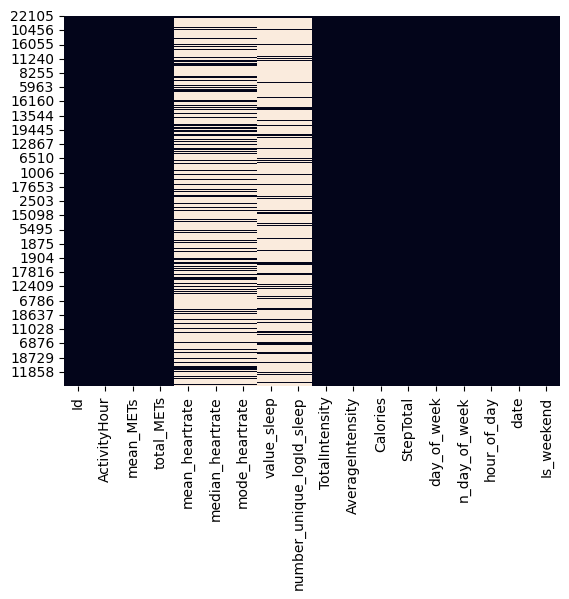

In [13]:
sns.heatmap(df.isnull(), cbar=False) # Chequeamos los nulos

Podemos ver que existe una gran cantidad de nulos en las columnas relacionadas a 'Sleep' y 'Heartrate'. Mi hipótesis es que algunas personas prefieren no trackear estas dimensiones. Corroboremoslo rápidamente

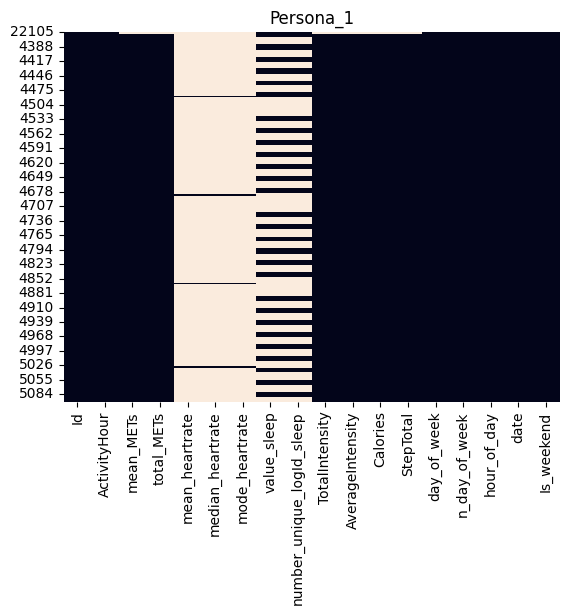

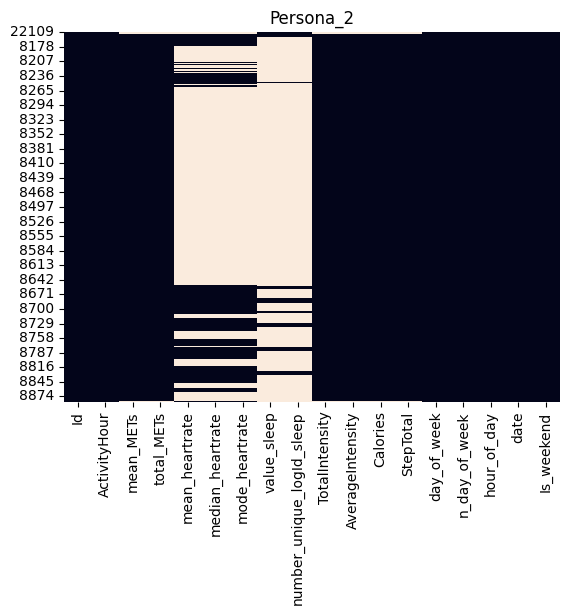

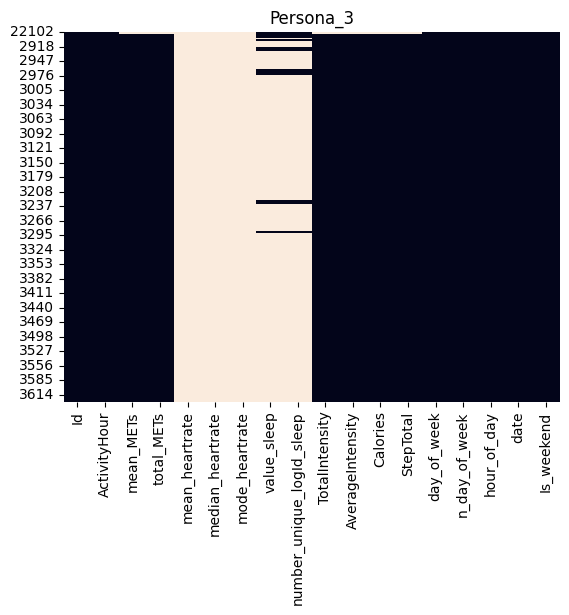

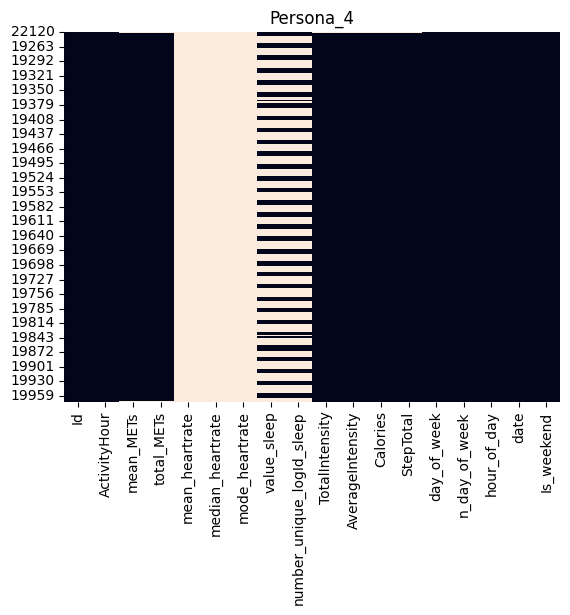

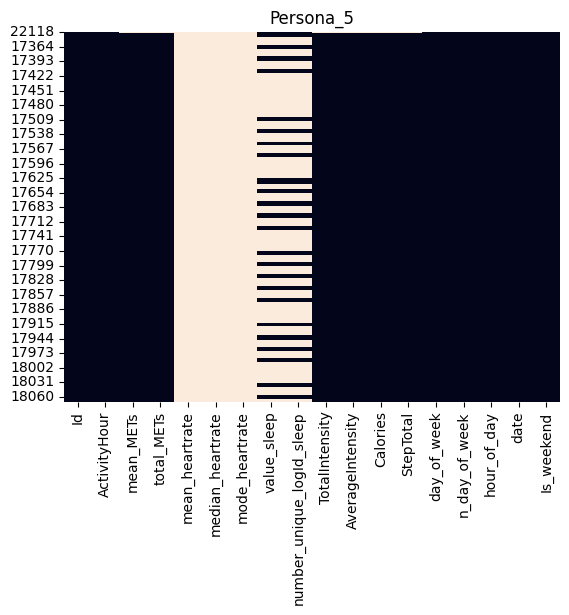

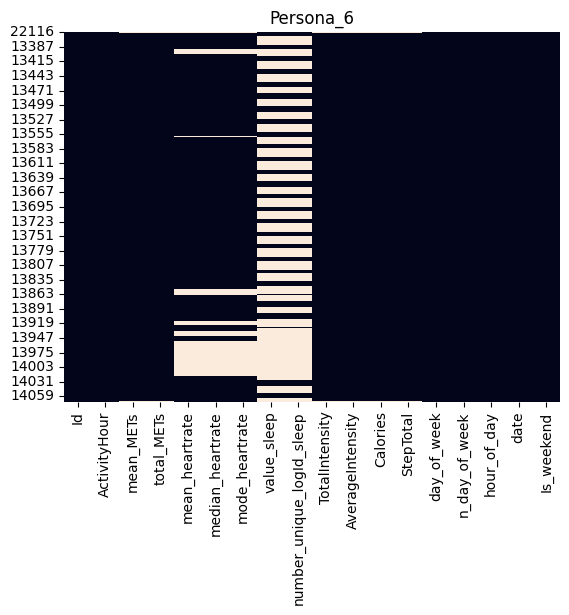

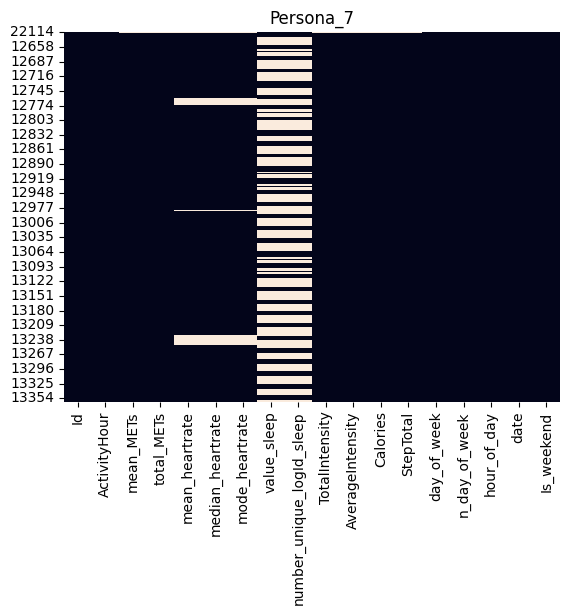

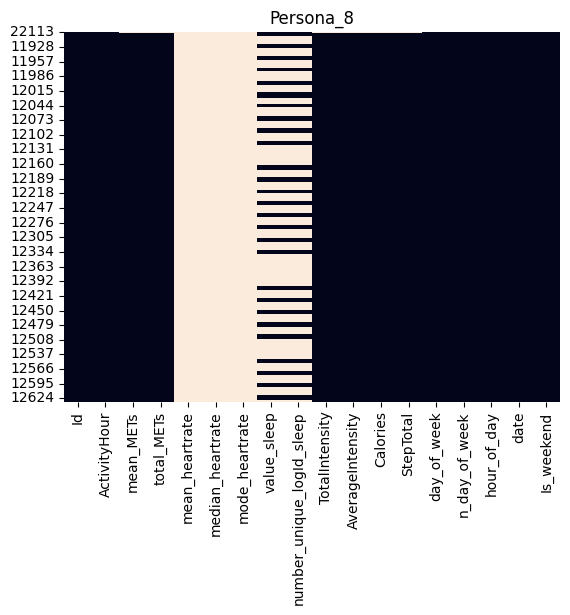

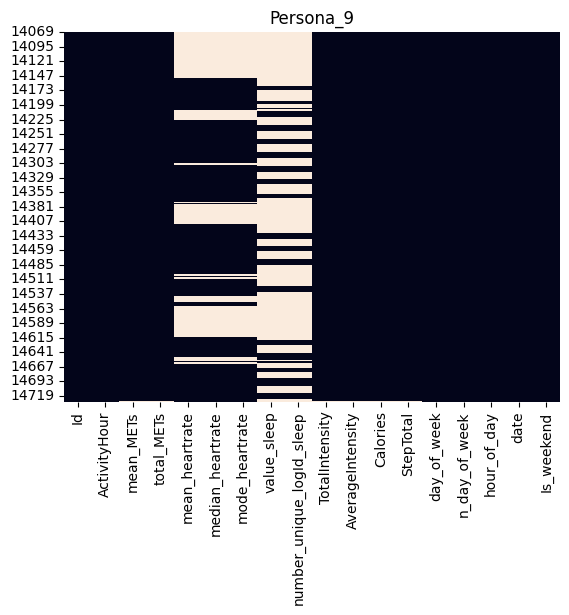

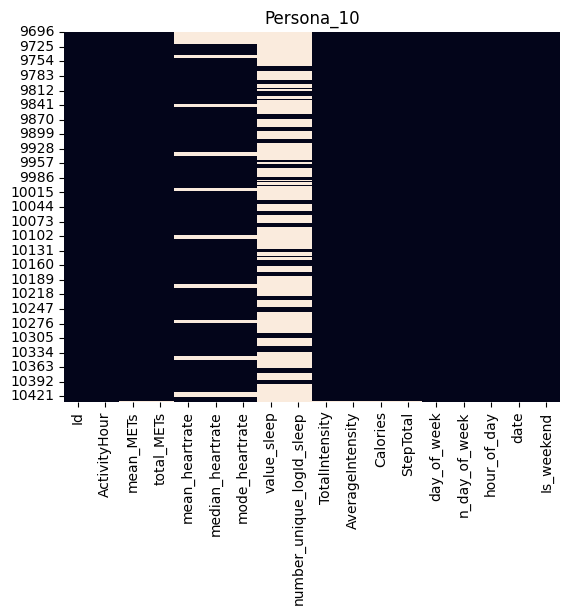

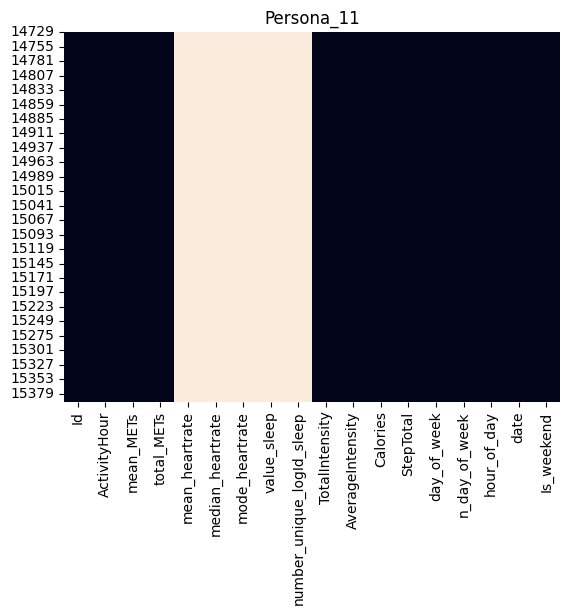

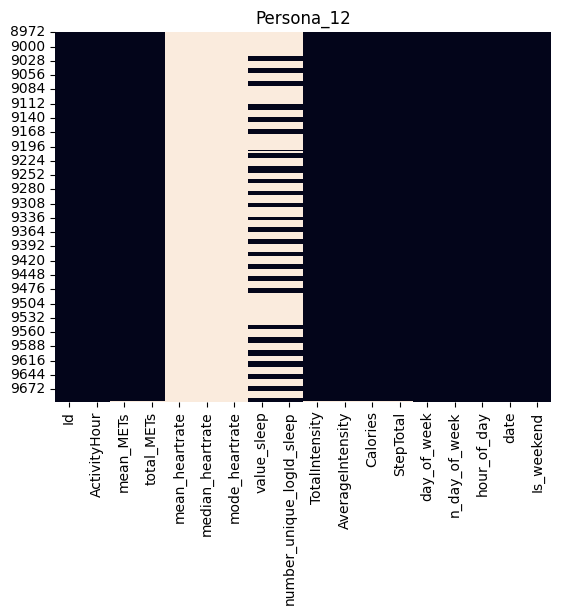

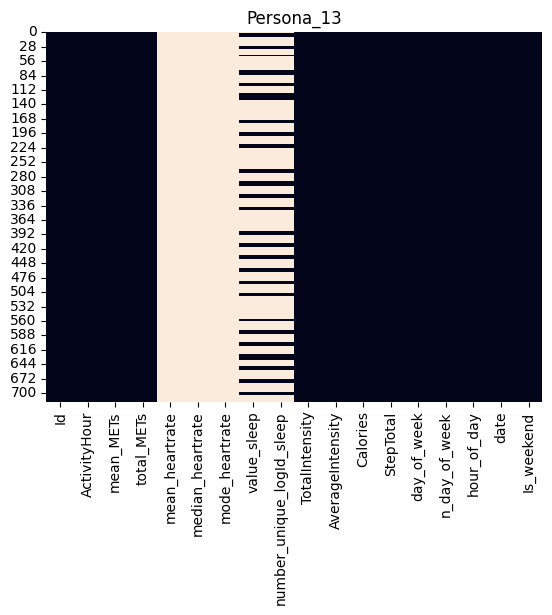

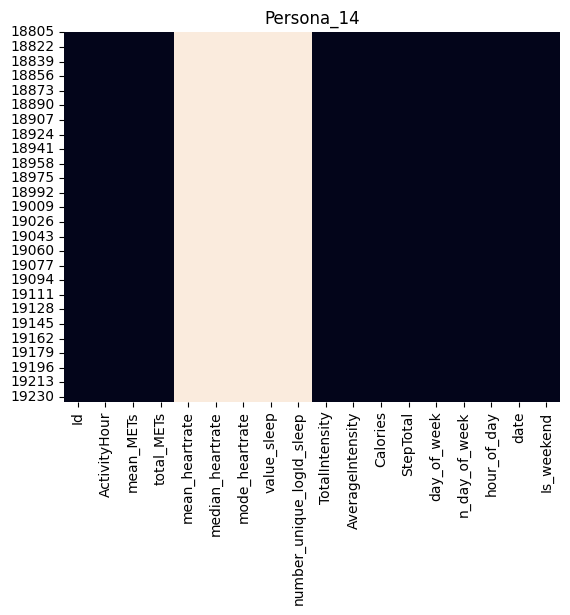

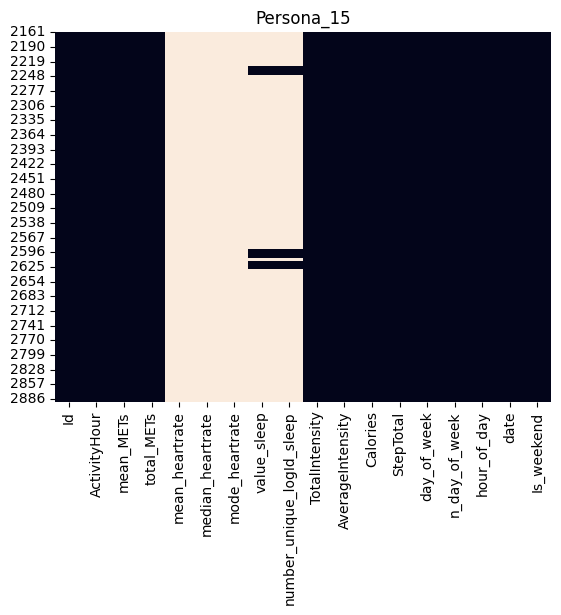

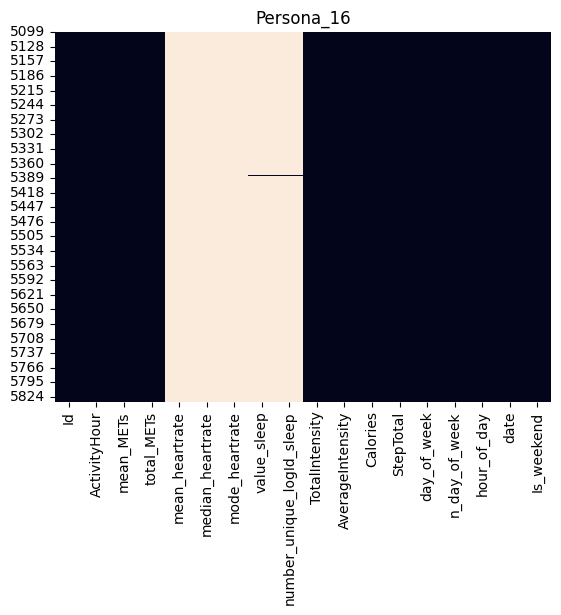

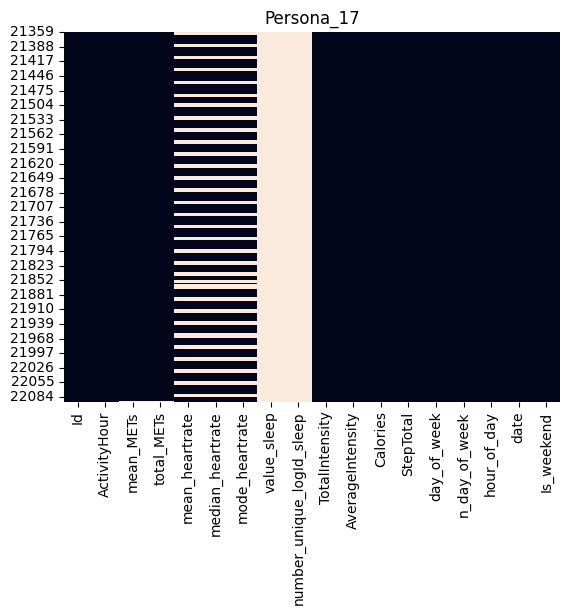

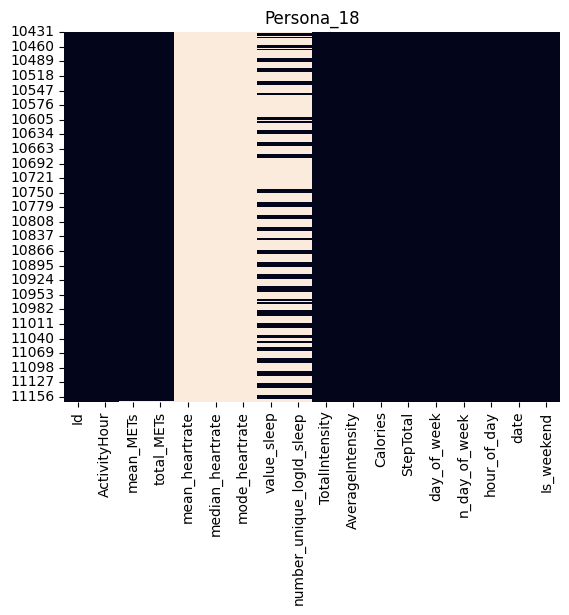

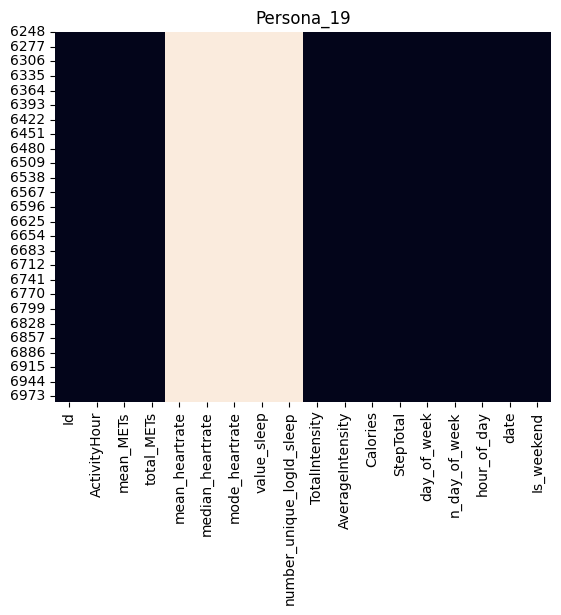

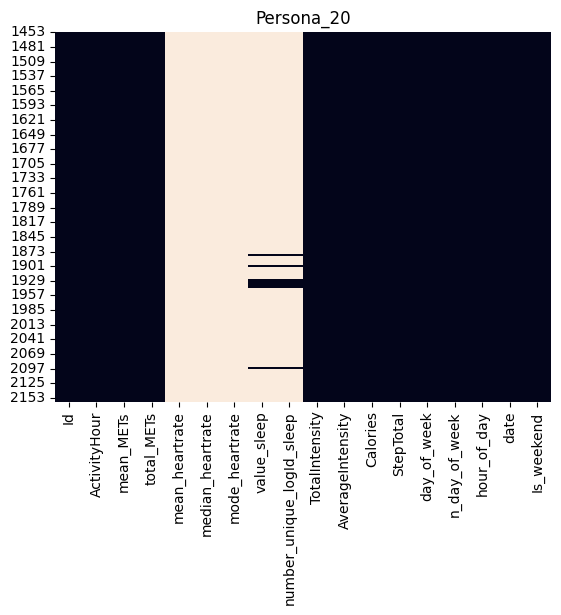

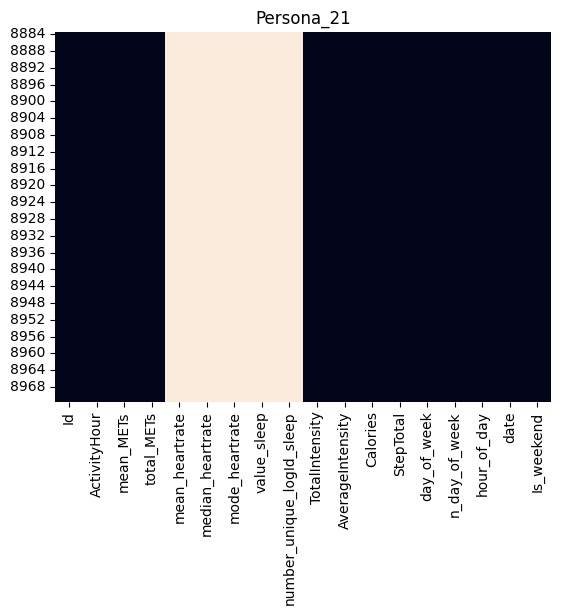

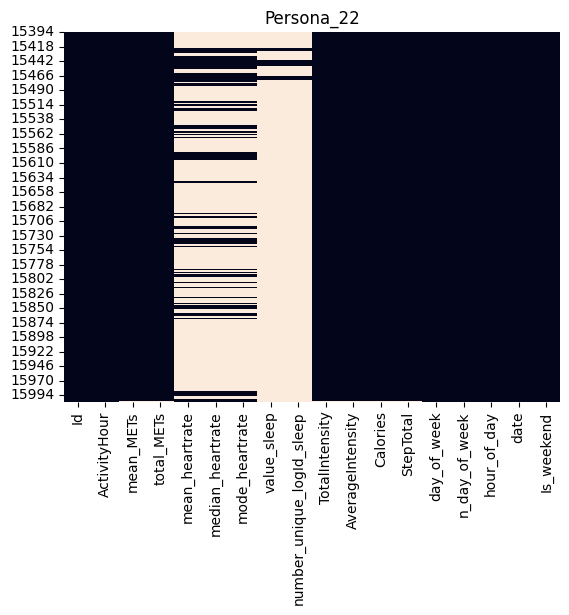

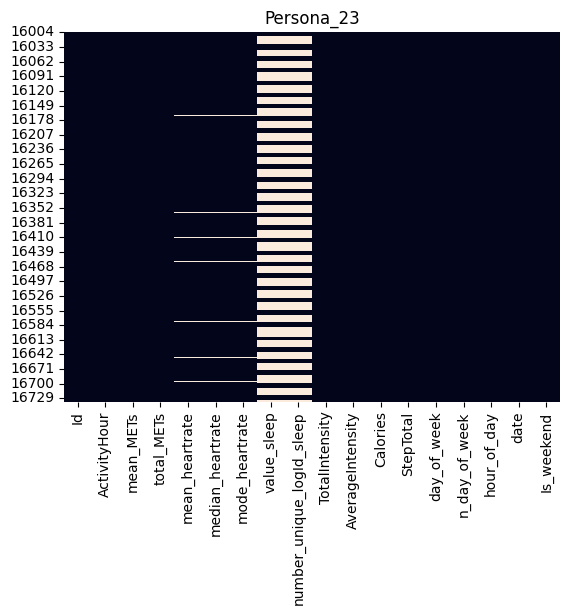

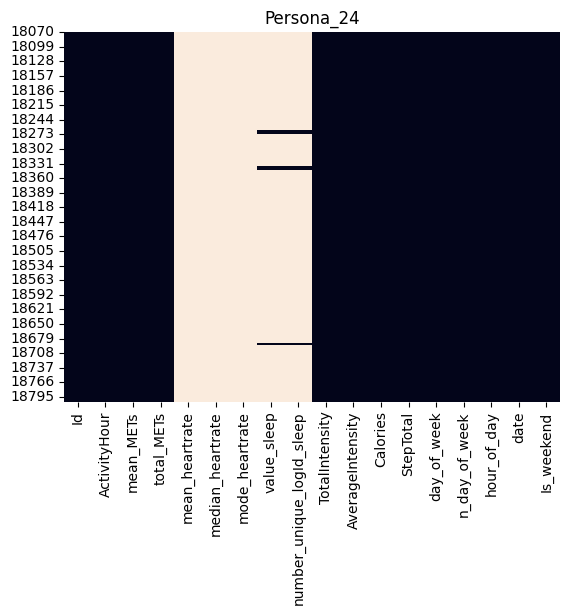

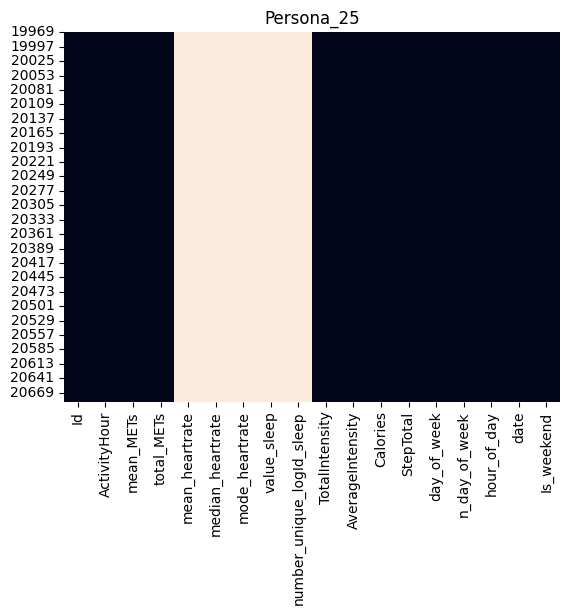

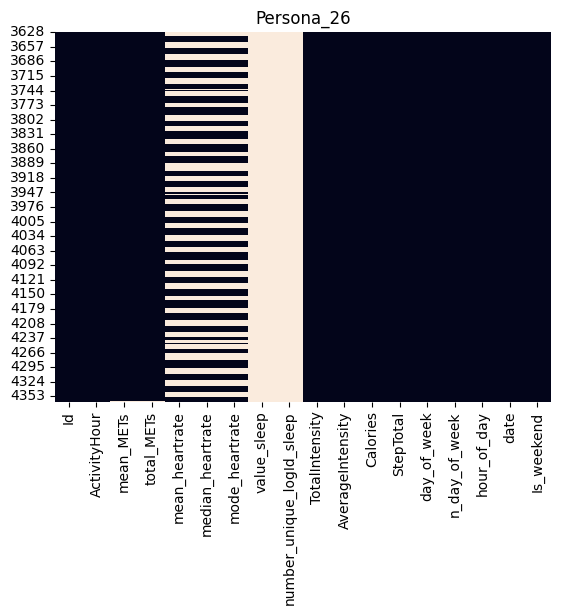

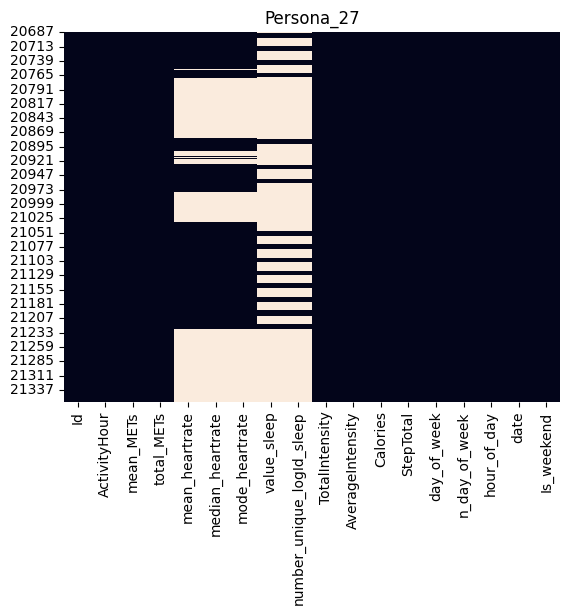

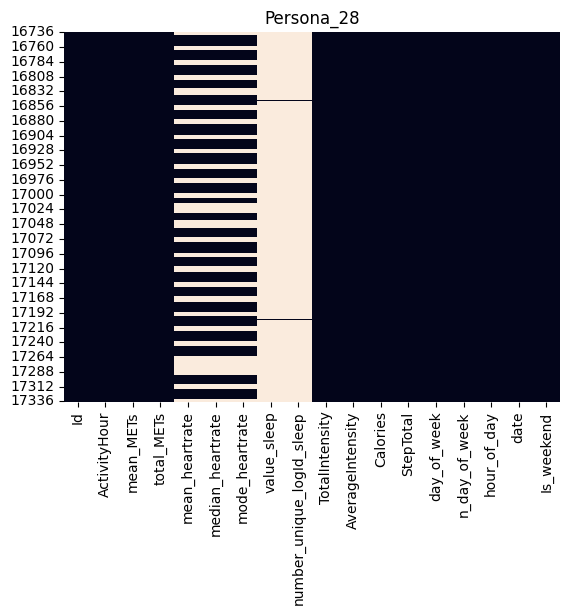

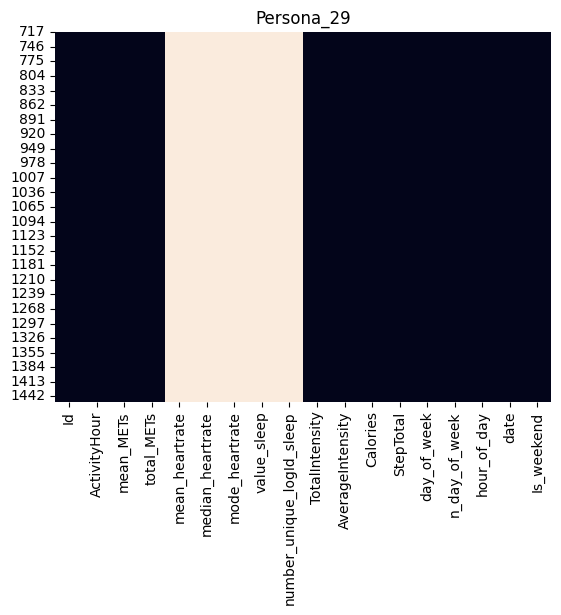

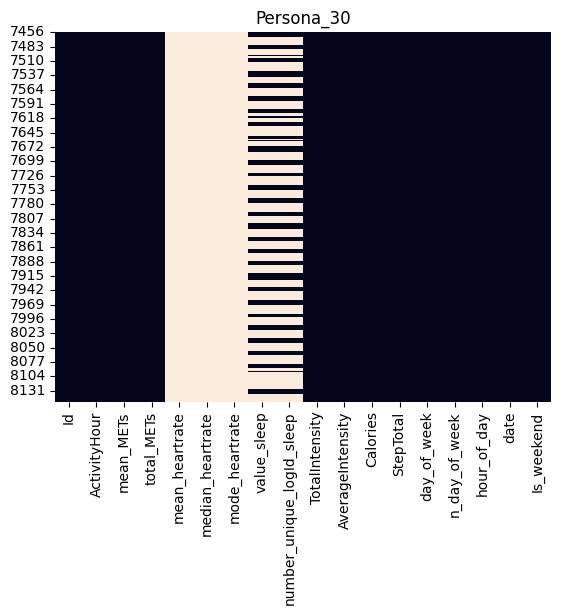

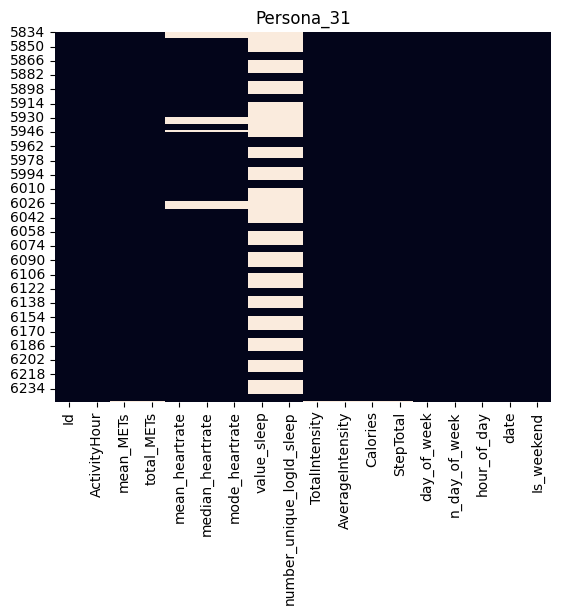

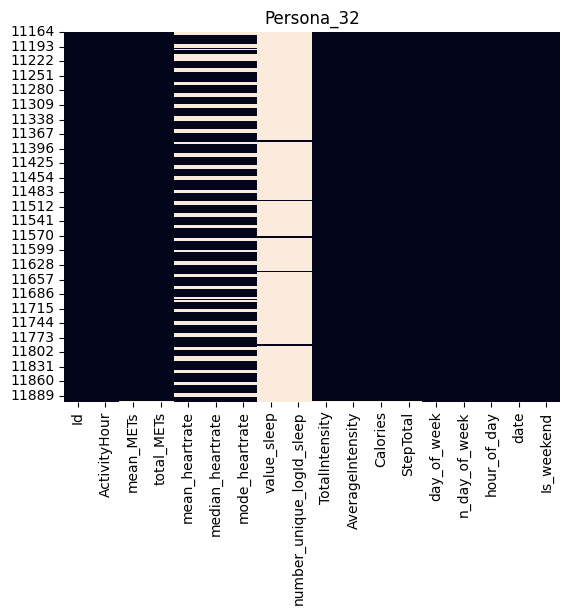

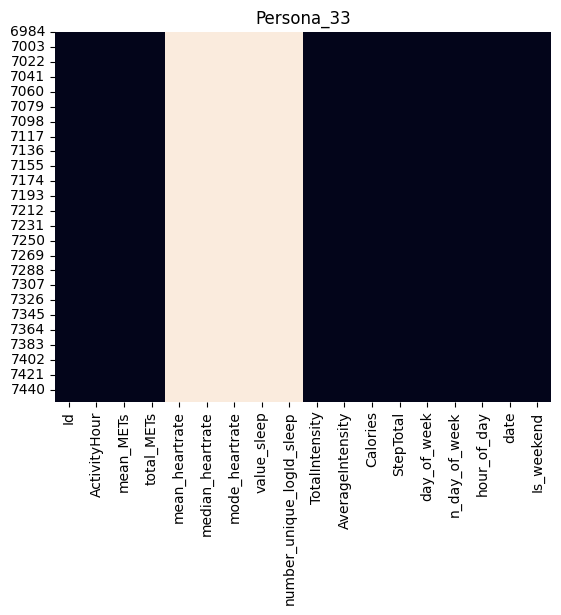

In [14]:
for id in df['Id'].unique():
    df_per_id = df[df['Id'] == id]
    sns.heatmap(df_per_id.isnull(), cbar=False)
    plt.title(str(id))
    plt.show()

Podemos decir que los nulos de Heartrate son porque estas personas no quisieron o no fueron constante en este trackeo. El caso de Sleep es similiar, pero, por si acaso, revisemos si estos "nulos" no son solo horas en las que nuestras persona están despiertas. Total no son enormes cantidades y lo podemos realizar ahora.

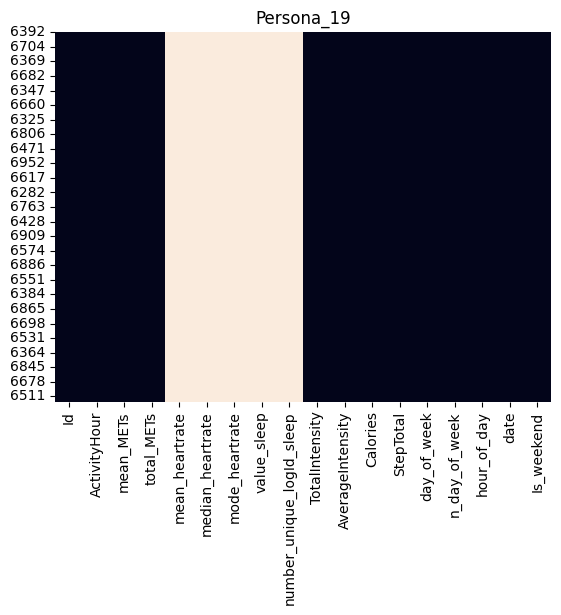

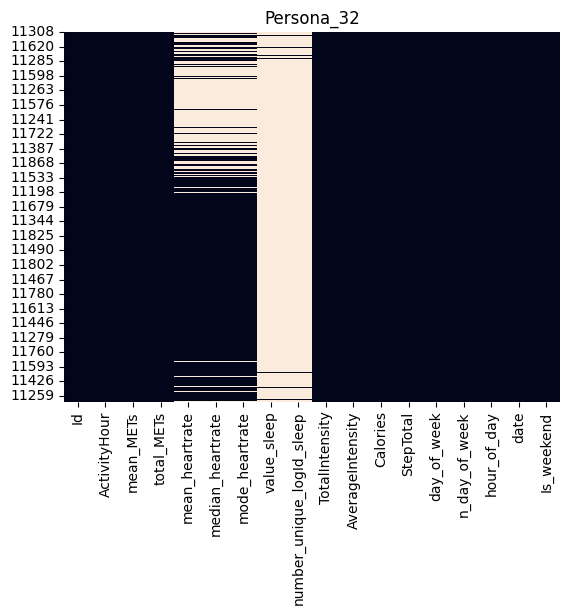

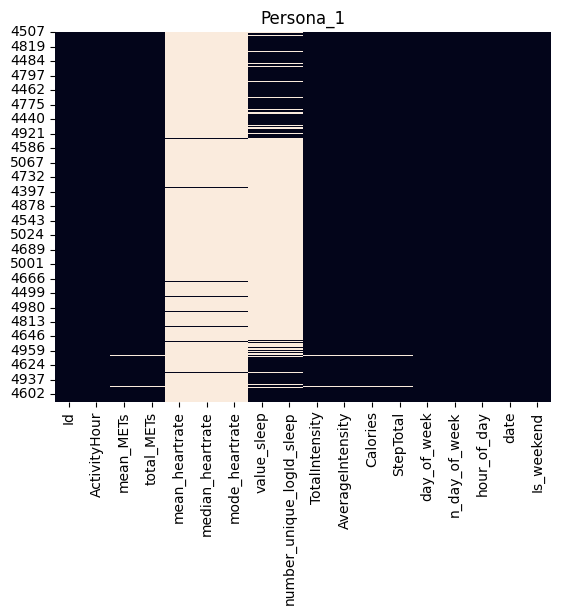

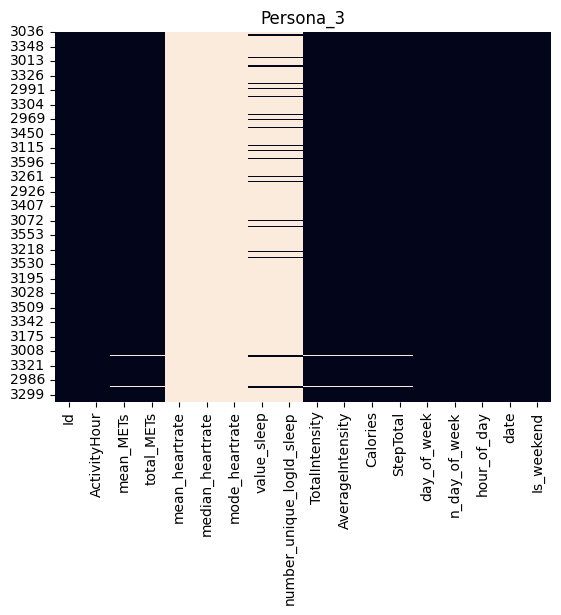

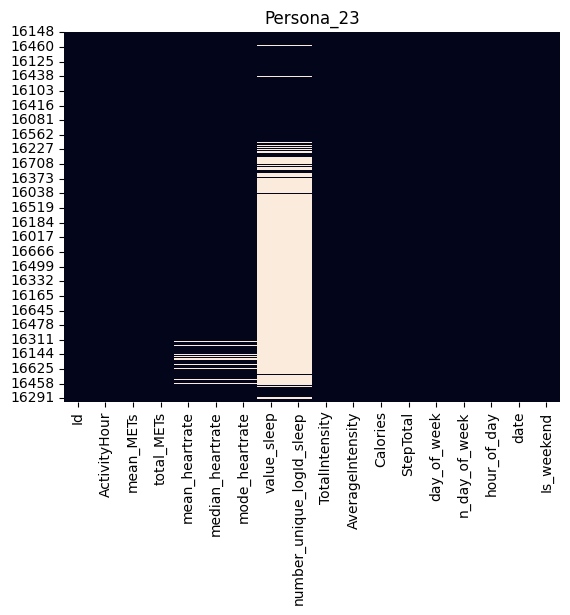

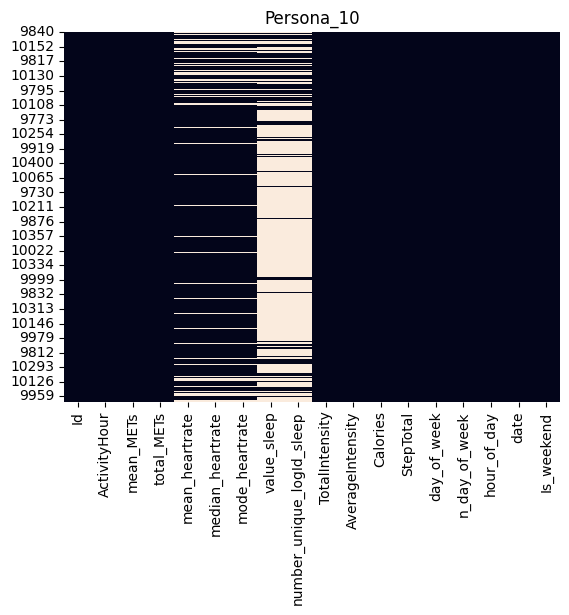

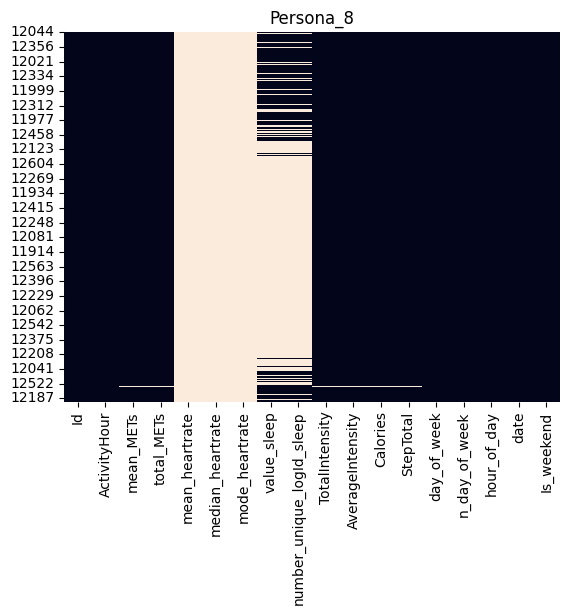

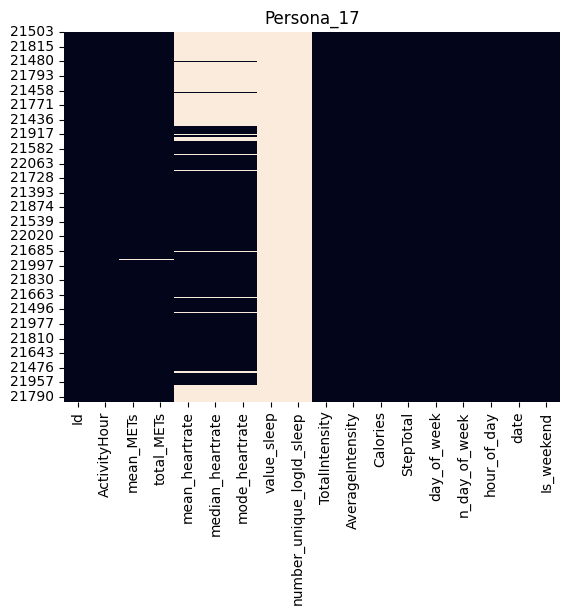

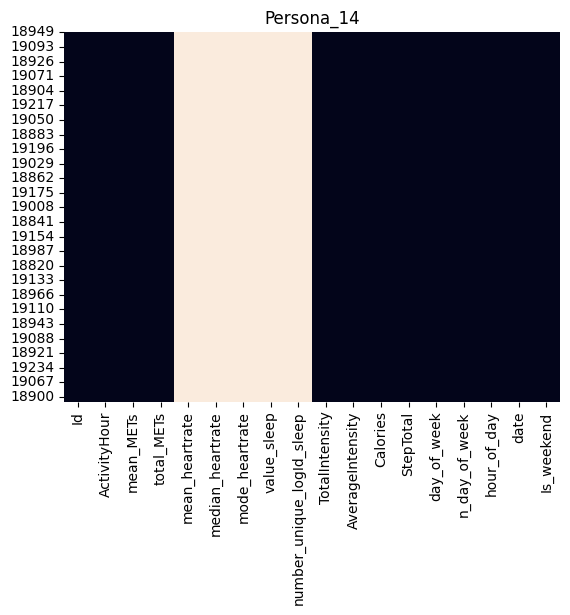

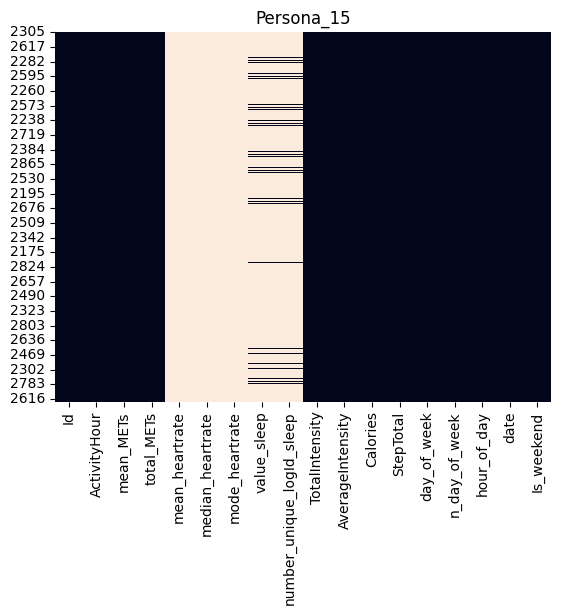

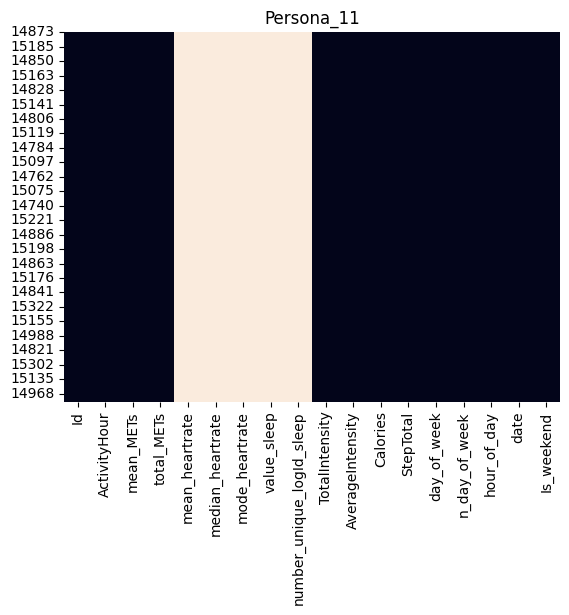

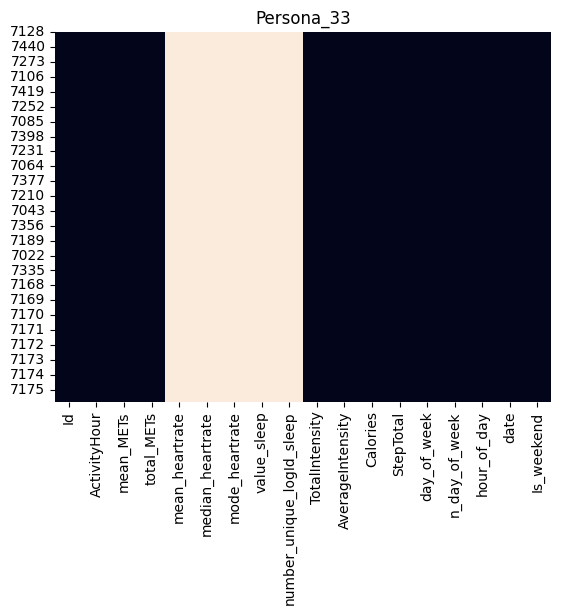

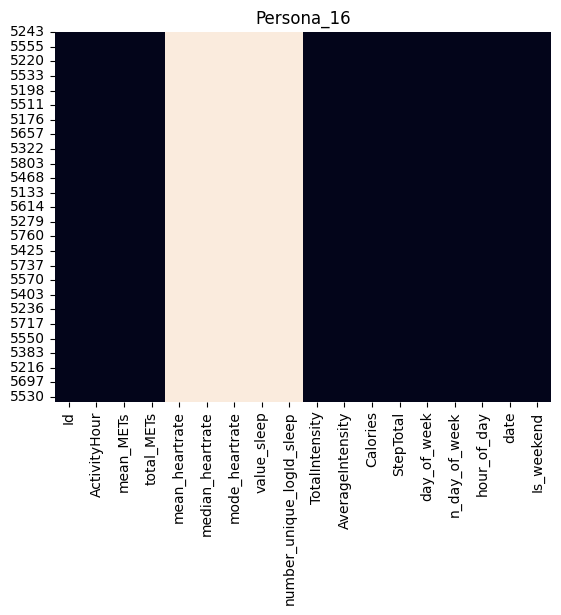

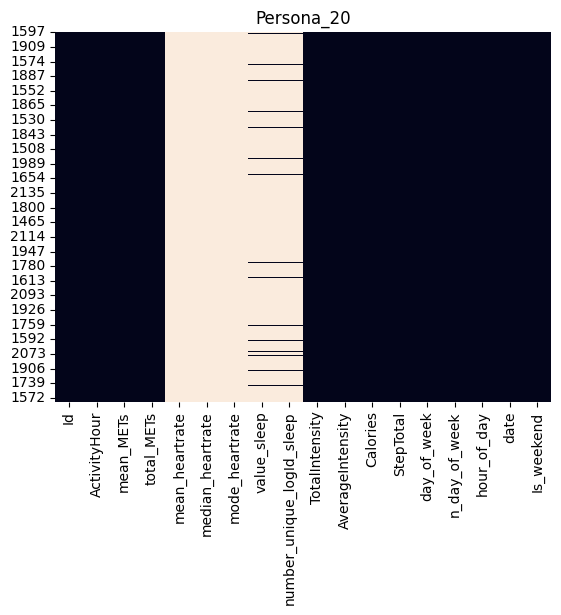

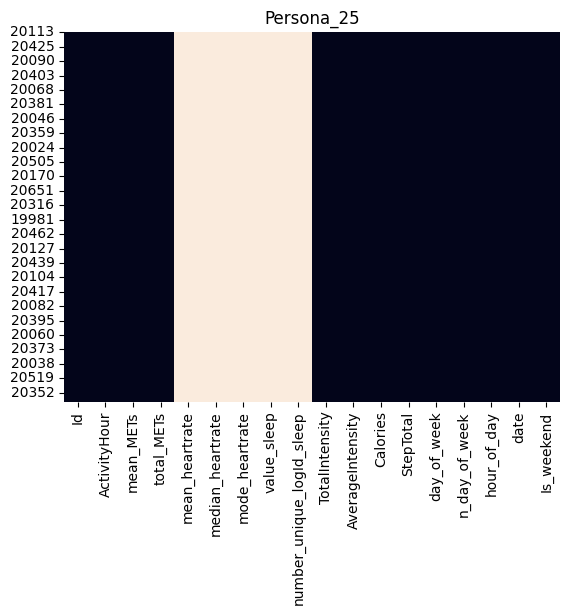

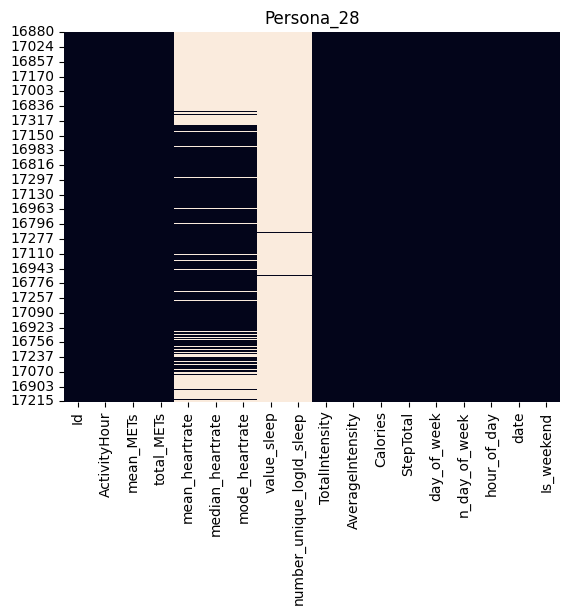

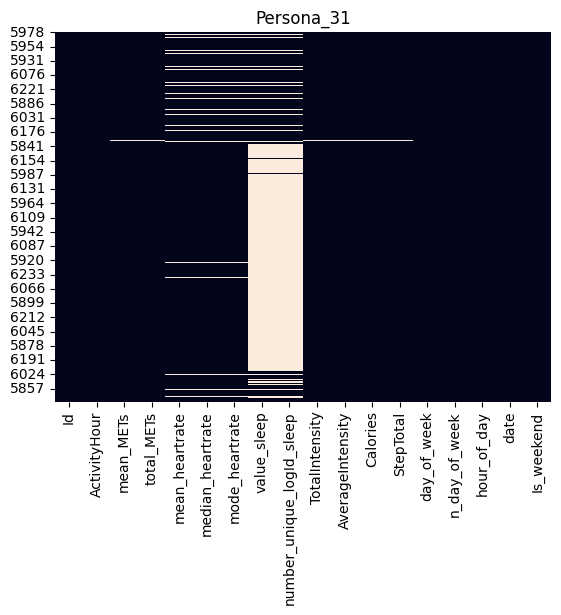

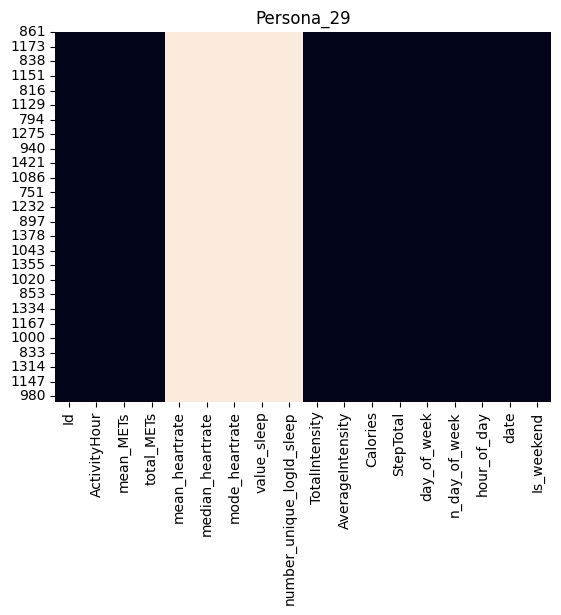

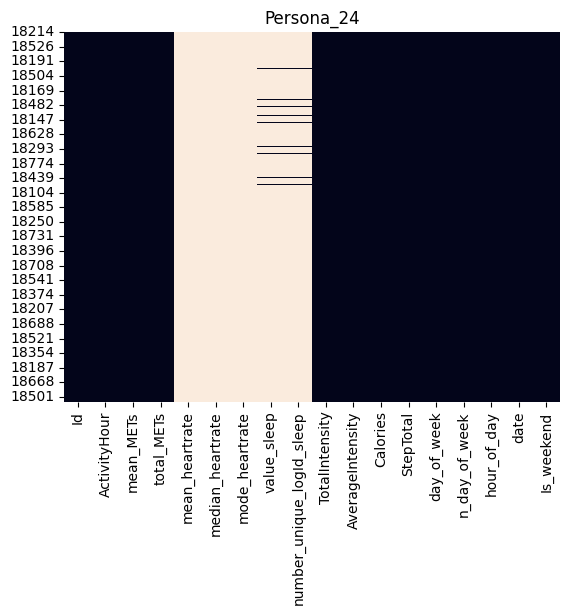

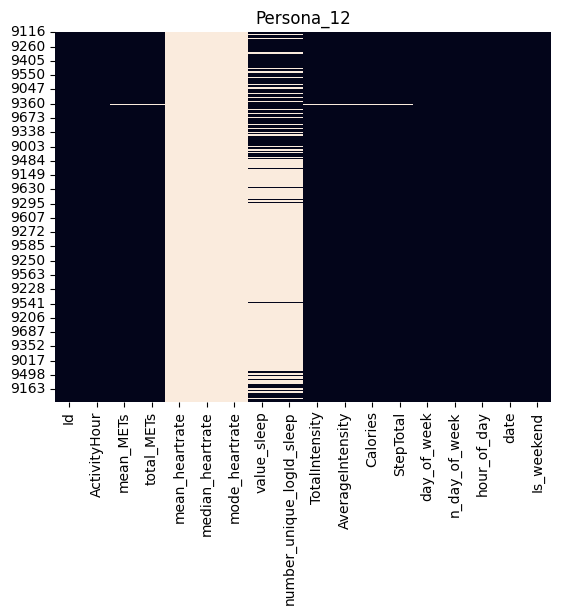

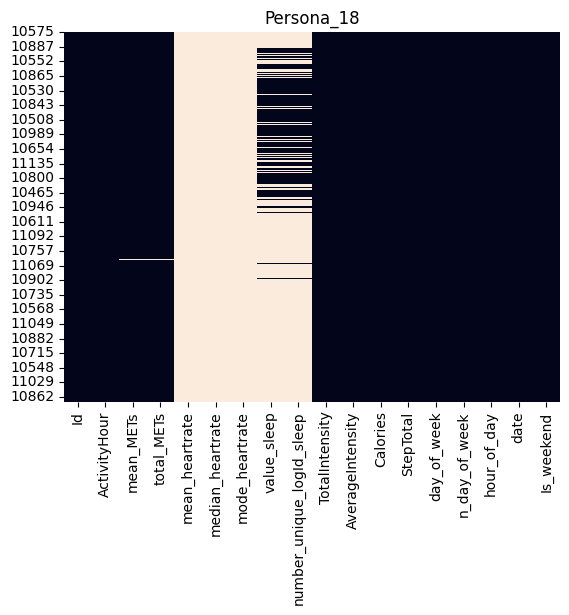

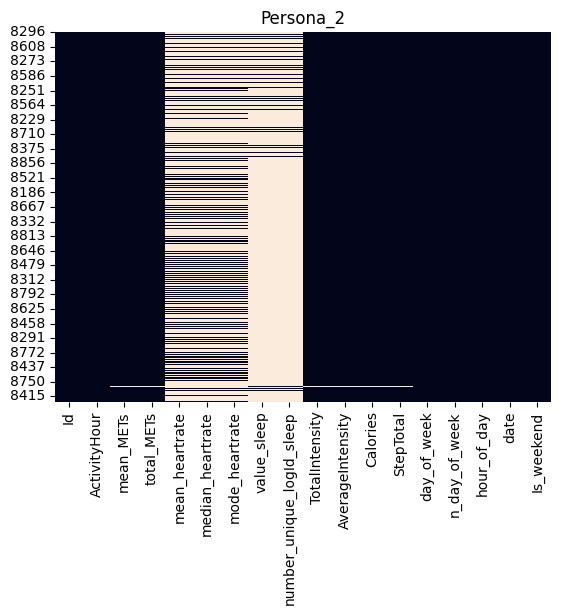

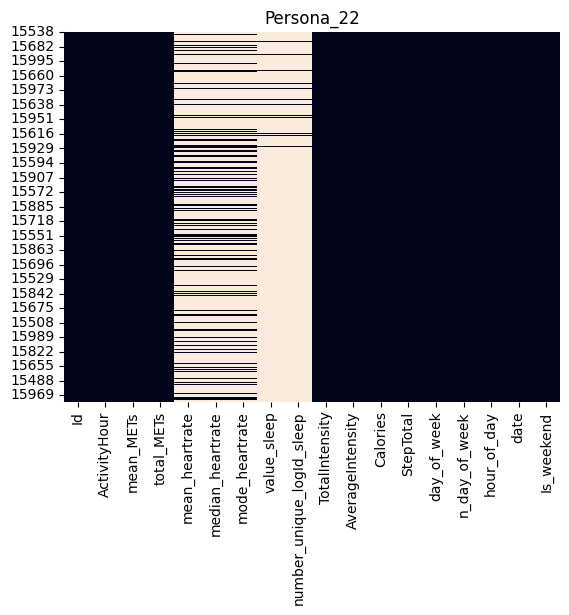

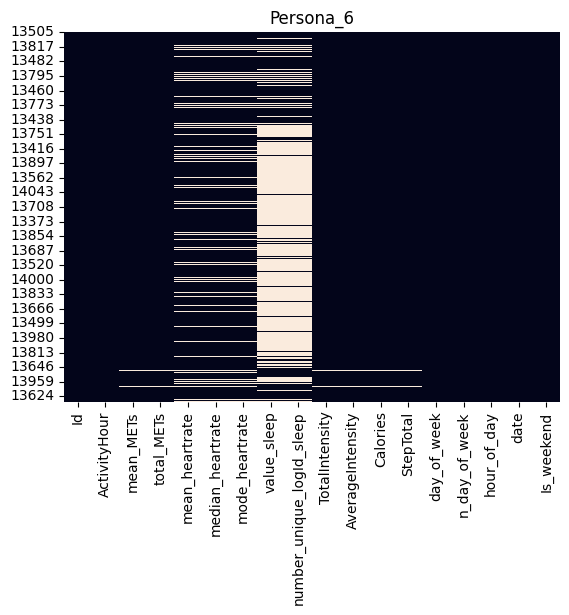

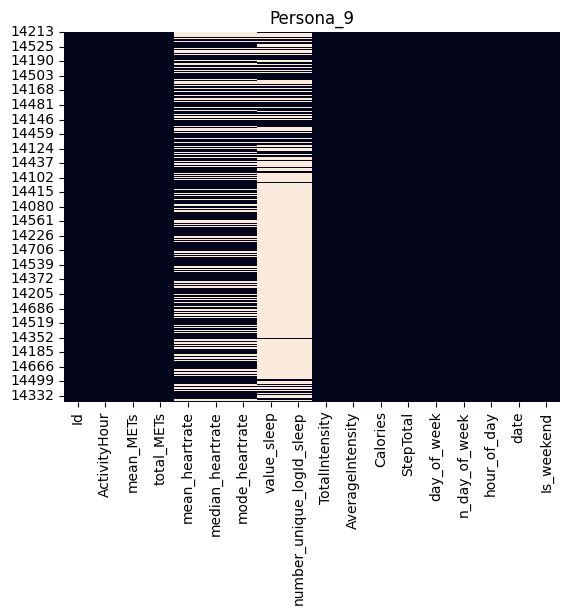

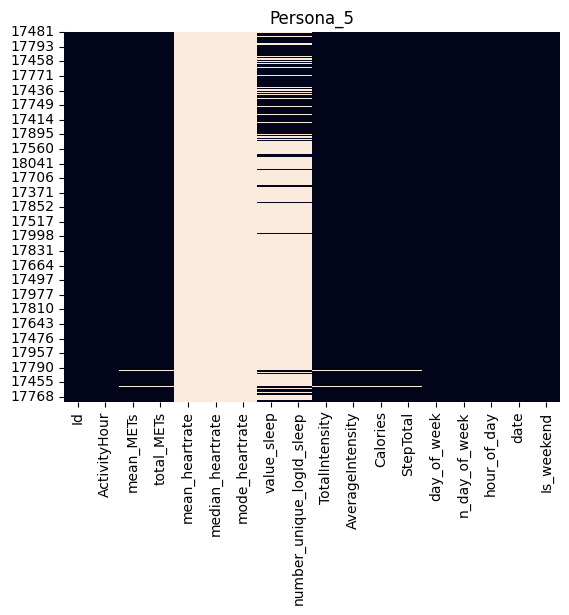

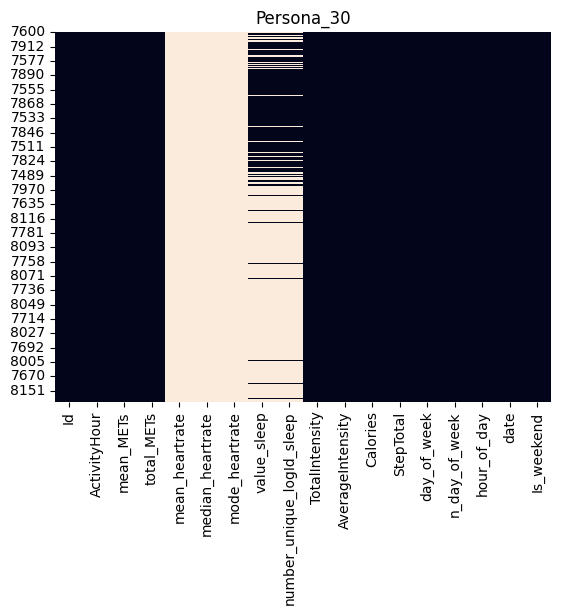

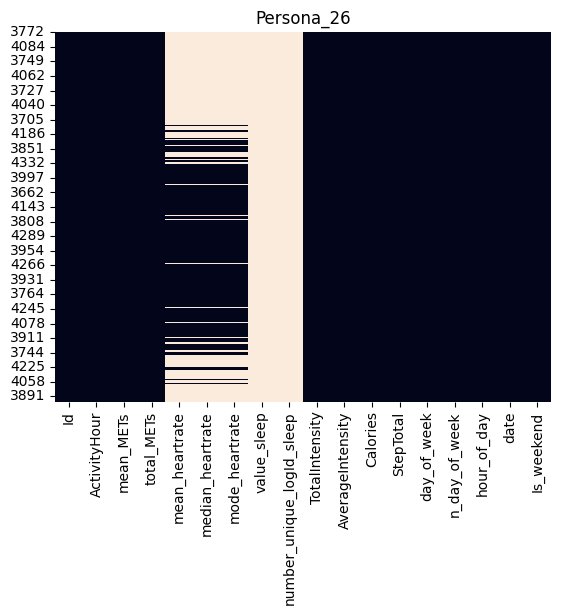

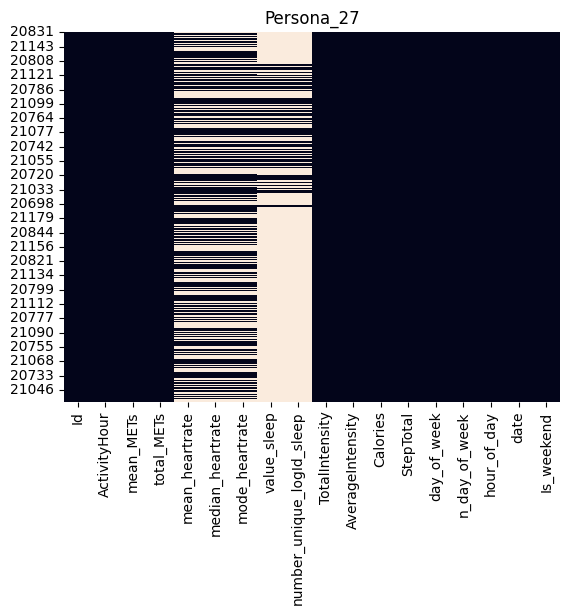

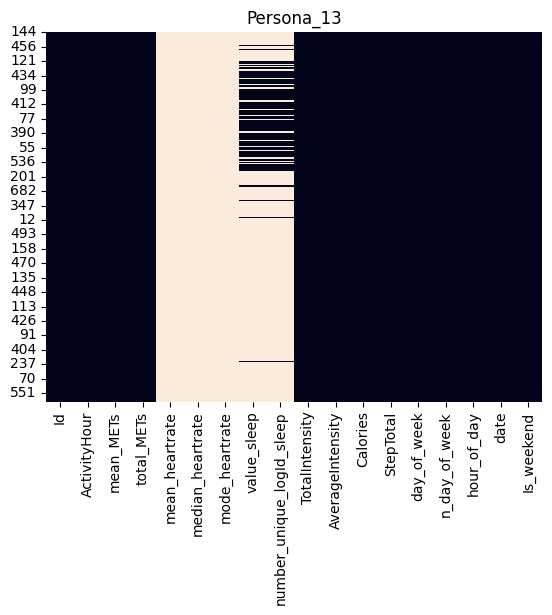

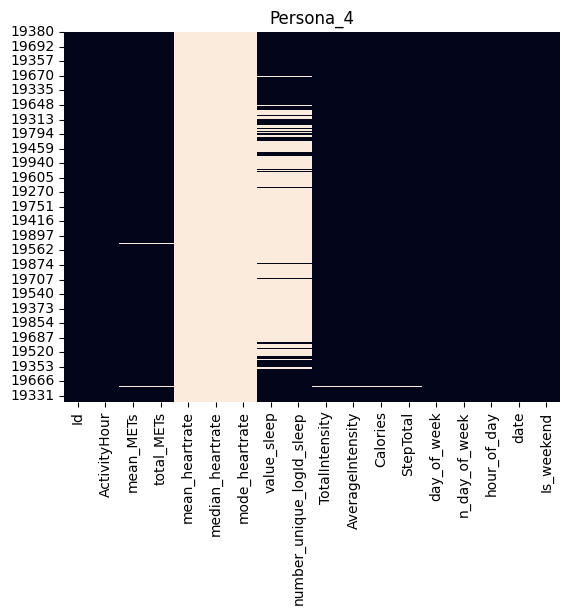

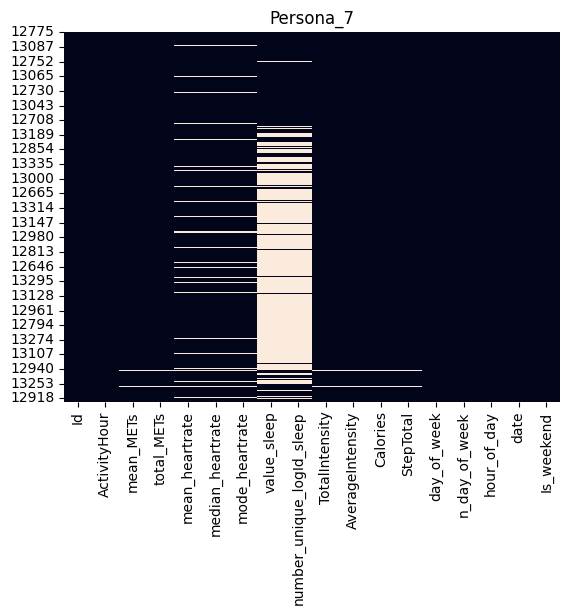

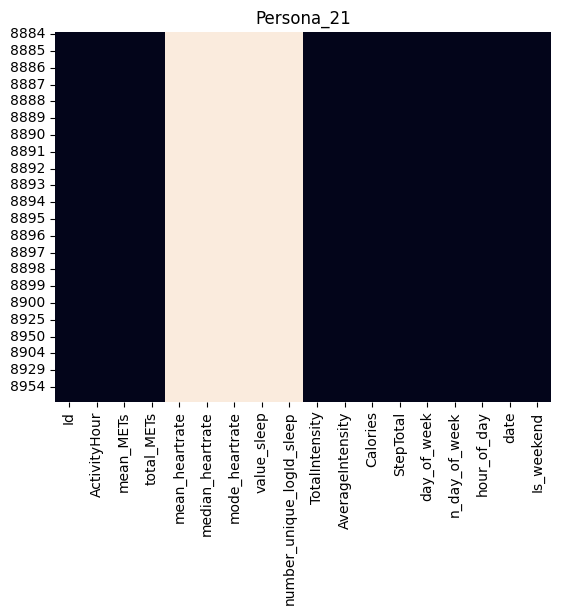

In [15]:
df = df.sort_values(axis=0, by=['hour_of_day','n_day_of_week'])
for id in df['Id'].unique():
    df_per_id = df[df['Id'] == id]
    sns.heatmap(df_per_id.isnull(), cbar=False)
    plt.title(str(id))
    plt.show()

Sí parece que sí, y, no solo eso, sino también las existen horarios específicos en los que las personas trackean su heartrate. Pero, debido a la gran cantidad de nulos, obviaremos estas métricas.

Podríamos dividir las personas entre 3 grupos (No trackers, heart_rate tracker, sleep tracker) y analizar su comportamiento con en base a estos datos, pero, para aproximarnos a resultados y conclusiones más rápidas (Nuestro equipo de Marketing cuenta con ello) lo obviaremos.

In [10]:
# Eliminamos las columnas relacionadas a Sleep o Heartrate.
df = df.drop(columns=['mean_heartrate',
       'median_heartrate', 'mode_heartrate', 'value_sleep',
       'number_unique_logId_sleep'])

### Análisis de rutinas diarias

Existen varias maneras de ver estos números (Series de tiempo, histogramas, etc) pero creo que la más acertada sería usar Heatmaps, ya que estos nos darían un mejor panorama de las rutinas semanales de las personas por inviduo, de allí podríamos clasificarlos según este dato, entender porque se comportan de esta manera en particular y, junto con otros análsis, dar estos insights al equipo de marketing.

Así que. ¡Adelante!

In [11]:
# Elegimos que dimensiones vamos a analizar
metrics_to_analyse = df.columns[2:-5] #Las 2 primeras son Id y ActivityHour y las últimas son temporales
metrics_to_analyse

Index(['mean_METs', 'total_METs', 'TotalIntensity', 'AverageIntensity',
       'Calories', 'StepTotal'],
      dtype='object')

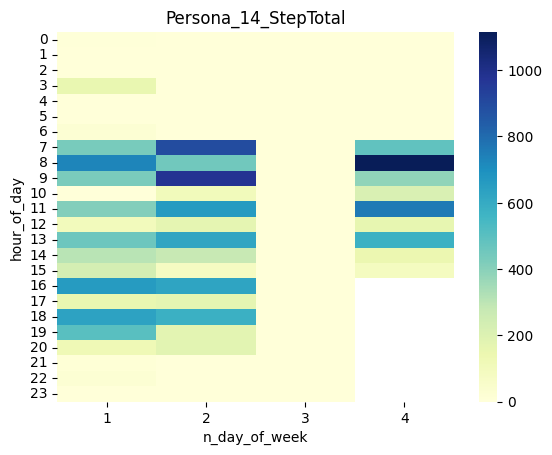

In [40]:
# Ahora con los datos de hour_of_day, n_day_of_week y la métrica a analizar (En este caso mean_METs) creamos un pivot_table
persona_analizar = 'Persona_14'
metric = 'StepTotal'
pivote = pd.pivot_table(df[df['Id'] == persona_analizar], index='hour_of_day',
                        columns='n_day_of_week', values=metric)
# Creamos ahora el heatmap
heatmap_plot = sns.heatmap(pivote, cmap="YlGnBu",annot=False)
plt.title(f'{persona_analizar}_{metric}')
plt.show() #Veamos como queda

In [41]:
(array_pivote / array_pivote.max()).mean()

0.19691548618539767

In [33]:
array_pivote.sum()

15464.4

In [47]:
columns = ['Id','colorfullness', 'max_step_total', 'sum_step_total', 'mean_step_total']
data = []

for persona in df['Id'].unique():
    # Perfil a analizar
    analyse_perfil_df = df[df['Id'] == persona]
    
    # Datos del perfil
    pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day',
                            columns='n_day_of_week', values='StepTotal')
    array_pivote = np.array(pivote).flatten()
    array_pivote = np.nan_to_num(array_pivote)
    
    # Metricas
    colorfullness = (array_pivote / array_pivote.max()).mean()
    max_step_total = array_pivote.max()
    sum_step_total = array_pivote.sum()
    mean_step_total = array_pivote.mean()
    data.append([persona, colorfullness, max_step_total, sum_step_total, mean_step_total])

In [49]:
see_persons = pd.DataFrame(data, columns=columns)

In [50]:
see_persons.head(3)

Id  colorfullness  max_step_total  sum_step_total  mean_step_total
0   Persona_7       0.243309          959.60         39224.6       233.479762
1  Persona_13       0.134527          684.25         15464.4        92.050000
2   Persona_5       0.069322          566.75          6600.4        39.288095

'max_step_total'

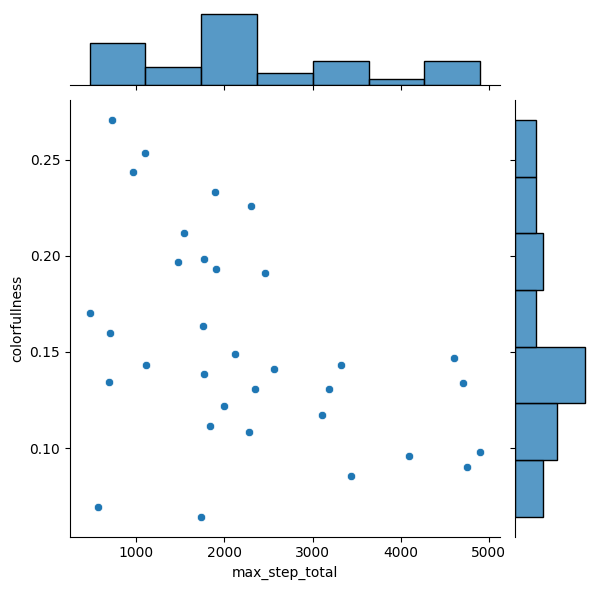

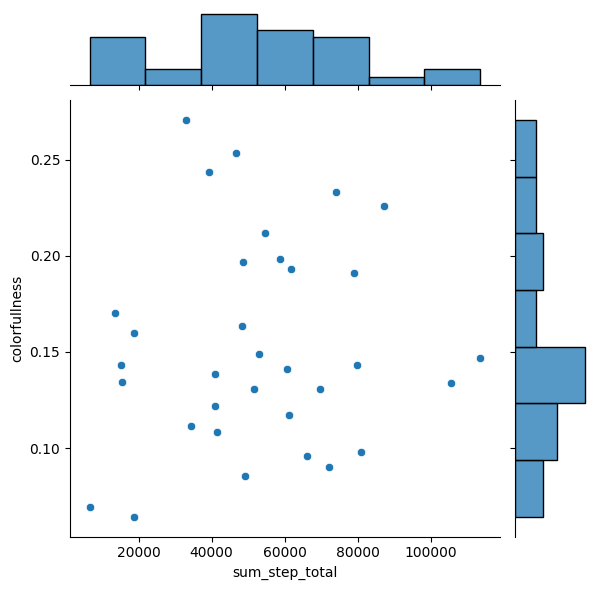

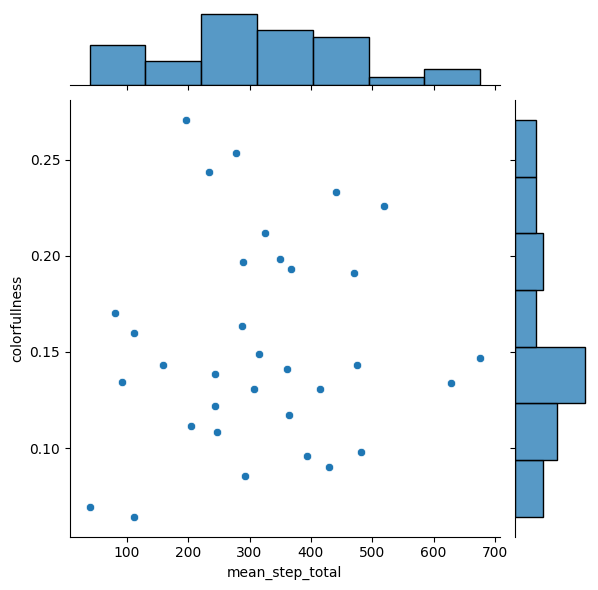

In [54]:
for i in range(2,5):
    sns.jointplot(x=see_persons.columns[i], y="colorfullness", data=see_persons)
    plt.show()

In [ ]:
sns.jointplot(x="sum_step_total", y="colorfullness", data=see_persons)

In [ ]:
sns.jointplotsee_persons

Cool. Ahora veamos para cada métrica de cada persona

In [ ]:
metrics_to_analyse = df.columns[2:-6] #Las 2 primeras son Id y ActivityHour y las últimas son temporales

number_graphs_per_person = len(metrics_to_analyse)

figsize = (number_graphs_per_person*5,number_graphs_per_person)


for persona in df['Id'].unique():
    fig, axes = plt.subplots(1,number_graphs_per_person ,figsize=figsize)
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        my_ax = axes[index]
        heatmap_plot = sns.heatmap(pivote, cmap="YlGnBu",annot=False,ax=my_ax)
        my_ax.set_title(f'{persona}_{metric}')
    fig = heatmap_plot.get_figure()
    plt.show()
    name_png = f'{persona}_{metric}_.png'
    fig.savefig(name_png)

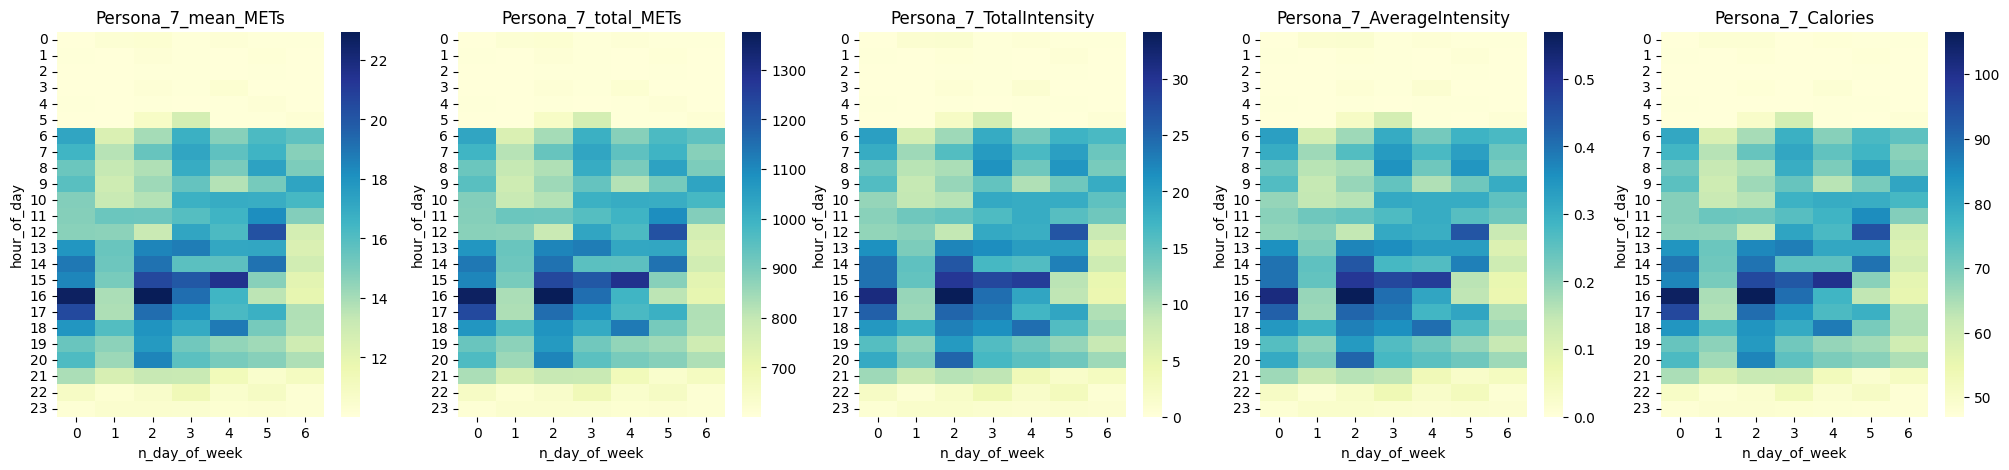

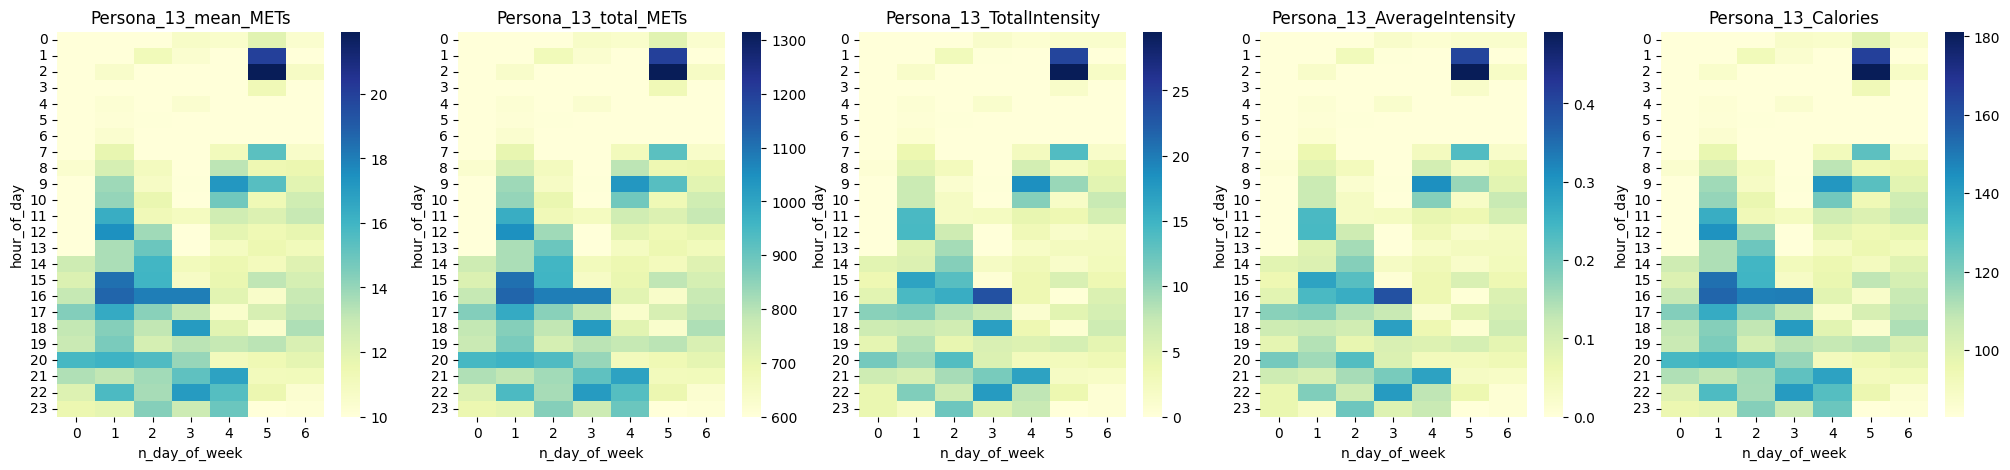

KeyboardInterrupt: 

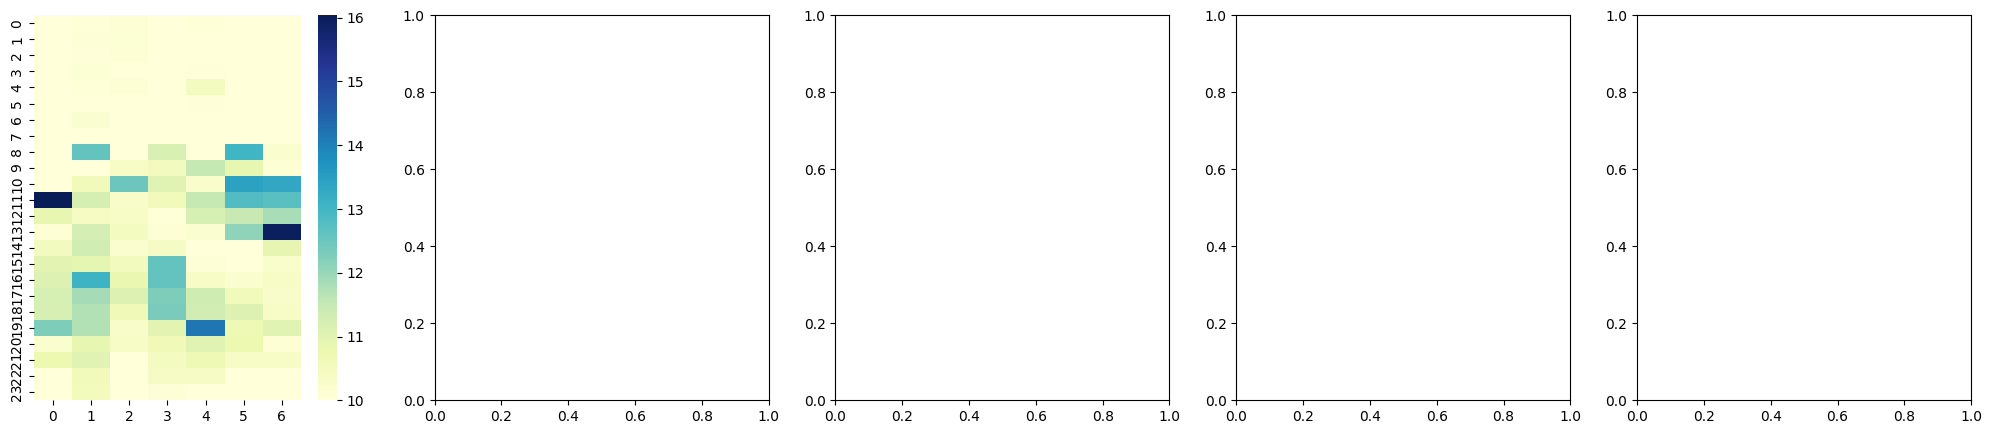

In [25]:
metrics_to_analyse = df.columns[2:-6] #Las 2 primeras son Id y ActivityHour y las últimas son temporales

number_graphs_per_person = len(metrics_to_analyse)

figsize = (number_graphs_per_person*5,number_graphs_per_person)


for persona in df['Id'].unique():
    fig, axes = plt.subplots(1,number_graphs_per_person ,figsize=figsize)
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        my_ax = axes[index]
        heatmap_plot = sns.heatmap(pivote, cmap="YlGnBu",annot=False,ax=my_ax)
        my_ax.set_title(f'{persona}_{metric}')
    fig = heatmap_plot.get_figure()
    plt.show()
    name_png = f'{persona}_{metric}_.png'
    fig.savefig(name_png)

### Explicar a las conclusiones a las que he llegado con las imágenes

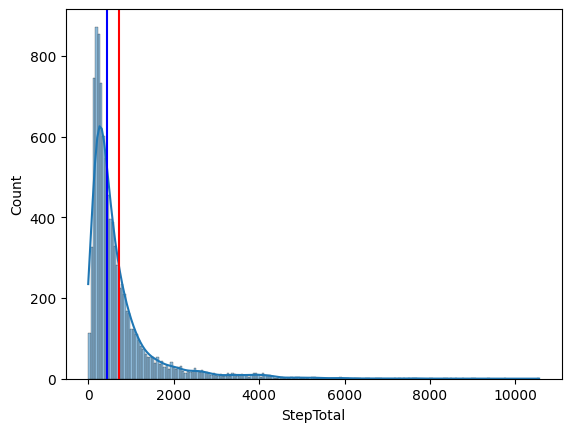

In [21]:
no_0s = df[df["mean_METs"] > 12.5]
median = no_0s['StepTotal'].median()
mean = no_0s['StepTotal'].mean()
sns.histplot(data=no_0s, x="StepTotal", kde=True)
plt.axvline(median, color='blue')
plt.axvline(mean, color='red')

In [18]:
median

432.0

In [20]:
median_abs_difference = median_abs_deviation(no_0s['StepTotal'])
median_abs_difference

237.0

In [23]:
for i in range(4):
    print(median_abs_difference* (i+1))

237.0
474.0
711.0
948.0


In [64]:
# Definimos a runners who have excedeed 2 median deviations (948 step total) from the median.
# Below that number, they are called walkers.
df['Label'] = df.apply(lambda x: "runner" if
                       pd.pivot_table(df[df['Id'] == x["Id"]], index='hour_of_day', columns='n_day_of_week',values=metric, aggfunc='mean').max().max()
                       > 948.0 
                       else "walker", axis=1)

<AxesSubplot: xlabel='Label', ylabel='Count'>

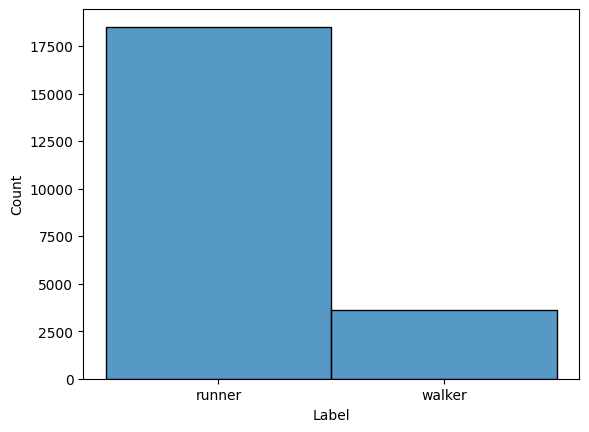

In [66]:
sns.histplot(data=df, x="Label")

Pase las imágenes a un Miro para empezar a agruparlas en patrones, noté que existen 3 tipos de usuarios de Fitbit en base a sus 'StepTotal' y ruina semanal en general.

- Los oficinistas: Los días de semana caminan hasta llegar al trabajo, salen y a veces caminan un poco más. Los fines salen a pasear.

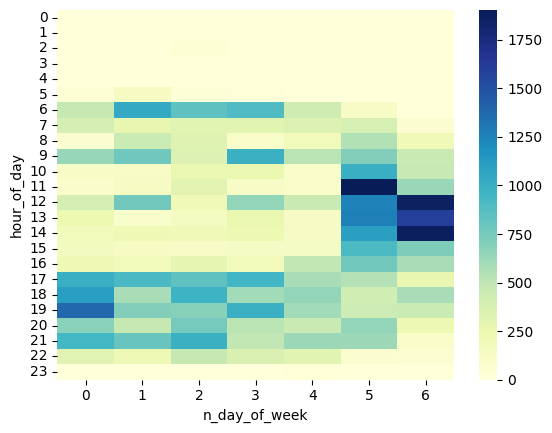

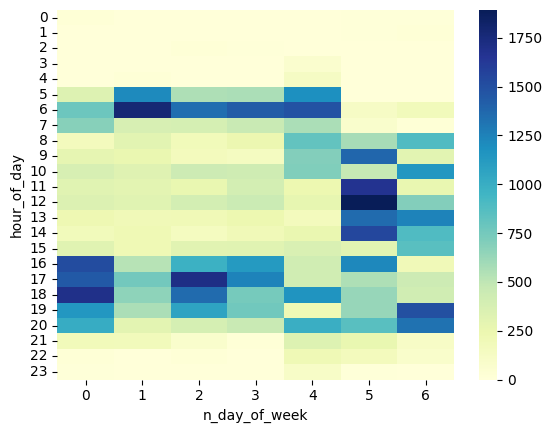

In [121]:
# Oficinistas:
metrics_to_analyse = ['StepTotal']
number_graphs_per_person = len(metrics_to_analyse)

for persona in ['Persona_19','Persona_16']:
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        # The graph
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        sns.heatmap(pivote, cmap="YlGnBu",annot=False)
        plt.show()

- Los corredores de 1 día: A diferencia del anterior, estos no tienen un horario de transporte a pie definido, tienen un día o 2 días en especial (Generalmente sábados, domingos y lunes) donde salen a correr o a pasear.

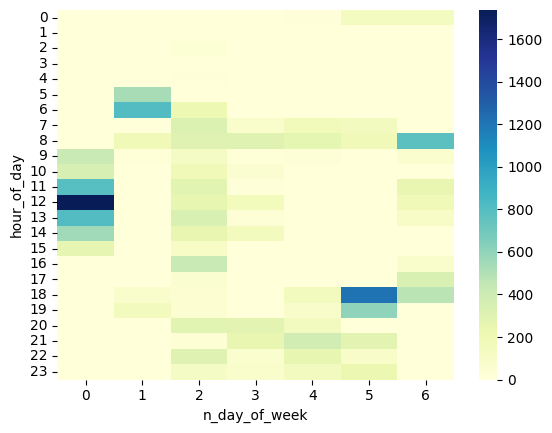

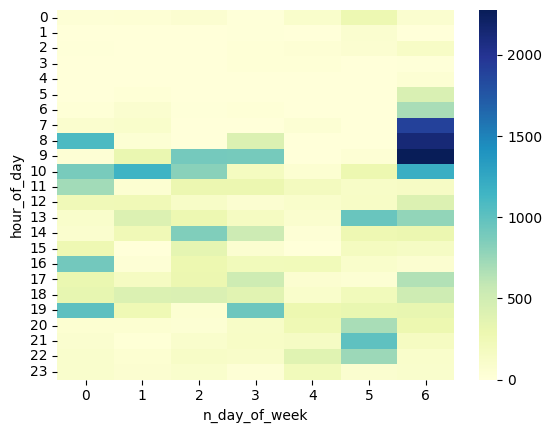

In [98]:
# Corredores:
metrics_to_analyse = ['StepTotal']
number_graphs_per_person = len(metrics_to_analyse)

for persona in ['Persona_24','Persona_2']:
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        # The graph
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        sns.heatmap(pivote, cmap="YlGnBu",annot=False)
        plt.show()

- Corredores diarios: Estas personas tienen generalmente una hora en específico cada día para correr y relajarse

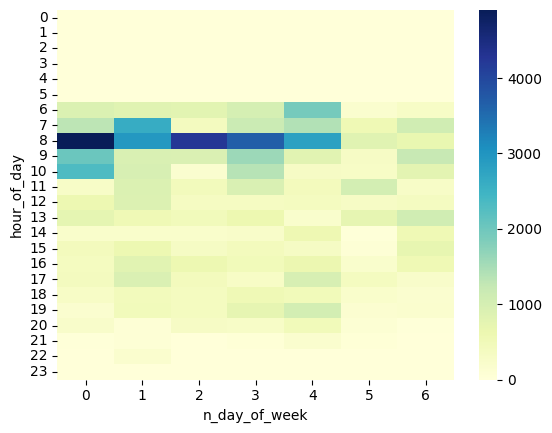

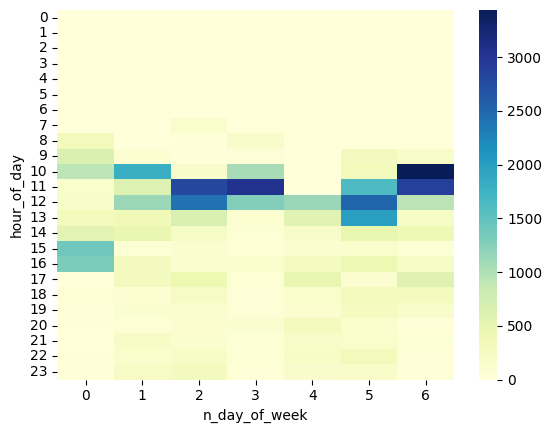

In [122]:
# Corredores:
metrics_to_analyse = ['StepTotal']
number_graphs_per_person = len(metrics_to_analyse)

for persona in ['Persona_26','Persona_29']:
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        # The graph
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        sns.heatmap(pivote, cmap="YlGnBu",annot=False)
        plt.show()

Nomadas: Están caminando o corriendo un gran parte de su tiempo, probablemente su trabajo tenga que ver con delivery o envíos.

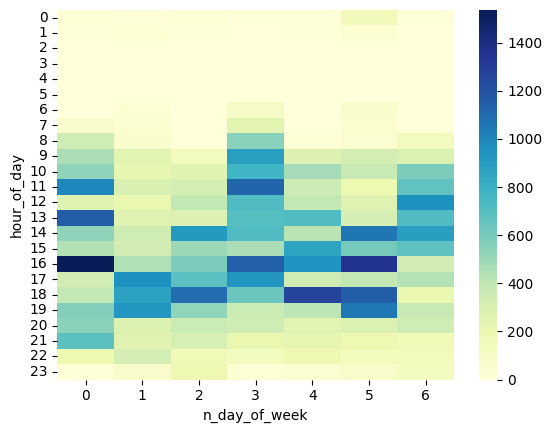

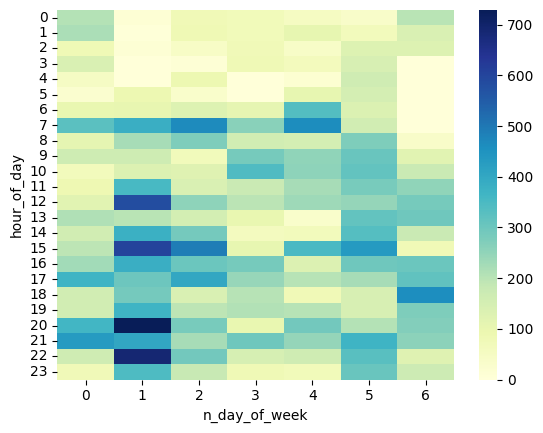

In [123]:
# Nomadas:
metrics_to_analyse = ['StepTotal']
number_graphs_per_person = len(metrics_to_analyse)

for persona in ['Persona_18','Persona_8']:
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        # The graph
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        sns.heatmap(pivote, cmap="YlGnBu",annot=False)
        plt.show()

Existe un quinto tipo, los sedentarios: Caminar solo si es necesario. Más que su rutina, ellos sobresalen por su cantidad de pasos menor al promedio

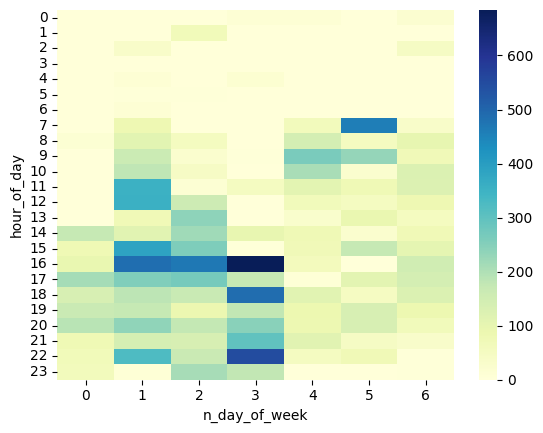

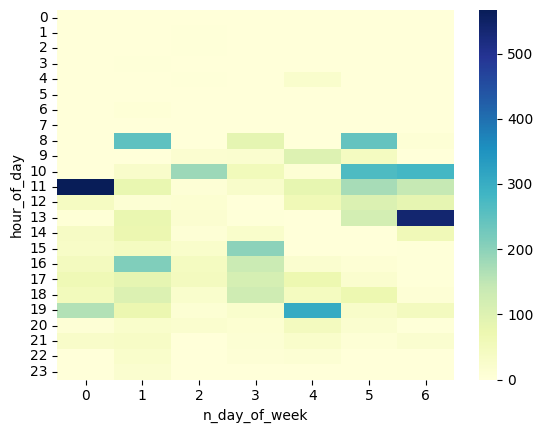

In [124]:
# Nomadas:
metrics_to_analyse = ['StepTotal']
number_graphs_per_person = len(metrics_to_analyse)

for persona in ['Persona_13','Persona_5']:
    analyse_perfil_df = df[df['Id'] == persona]
    for index, metric in enumerate(metrics_to_analyse):
        # The graph
        pivote = pd.pivot_table(analyse_perfil_df, index='hour_of_day', columns='n_day_of_week',values=metric)
        sns.heatmap(pivote, cmap="YlGnBu",annot=False)
        plt.show()